# OCOM510M Data Science: Assessment 2

Student ID: 201955872

## 1. Aims, Objectives and Plan

### 🎯 Aim

To develop a predictive data analysis model that can identify fraudulent insurance claims accurately, while minimizing customer churn due to false positives. The model should aim to achieve a **Balanced Error Rate (BER) close to 5%**, as per the client's business requirement.

### ✅ Objectives

- Understand the business case and explore the dataset.
- Preprocess the data:
  - Handle missing values, duplicates, and outliers.
  - Remove noisy or redundant features.
  - Scale, encode, and select features appropriately.
- Identify and address class imbalance in the dataset.
- Apply two machine learning techniques from the module (e.g., Logistic Regression and Random Forest).
- Integrate preprocessing and modeling into a pipeline with **Stratified Cross-Validation**.
- Optimize model hyperparameters using **GridSearchCV** or **Nested Cross-Validation**.
- Evaluate the models using performance metrics such as:
  - Balanced Error Rate (BER)
  - Precision, Recall, F1-score
  - Confusion Matrix
  - ROC-AUC and PR curves
- Estimate the financial impact of prediction errors using a custom pricing model.
- Recommend the best model based on both technical and business perspectives.

### ✅ Plan

```mermaid
gantt
    title 3-Week Iterative Plan for Fraud Detection Project
    dateFormat  YYYY-MM-DD
    excludes    weekends

    section Week 1 - Baseline Modeling
    Data Cleaning & Exploration       :done, a1, 2025-06-24, 2d
    Feature Engineering               :done, a2, after a1, 2d
    Baseline Model (LogReg & RF)     :done, a3, after a2, 2d
    Evaluation & Business Impact     :done, a4, after a3, 1d

    section Week 2 - Hyperparameter Tuning
    Prepare GridSearchCV             :active, b1, 2025-07-01, 1d
    Run Hyperparameter Tuning (LogReg + RF) :b2, after b1, 2d
    Evaluate + Compare with Baseline :b3, after b2, 2d

    section Week 3 - Nested CV & Reporting
    Setup Nested Cross-Validation    :c1, 2025-07-08, 1d
    Run + Evaluate Nested CV         :c2, after c1, 2d
    Final Business Analysis & Plots  :c3, after c2, 1d
    Report + Recommendations         :c4, after c3, 1d
```

## 2. Understanding The Case Study

### 🧾 Case Study Analysis

The client is an insurance company seeking to reduce financial losses due to fraudulent claims while avoiding unnecessary customer churn caused by false alarms. Their primary goal is to implement a predictive model that flags potential fraud accurately, with a **Balanced Error Rate (BER) target of 5%**, if achievable. The model must not only be technically robust but also aligned with the company’s operational priorities and financial impact.

Key challenges and strategic responses:

1. **Dual Cost of Prediction Errors**  
   - **False Negatives (FN)**: Undetected fraud results in direct financial loss.  
   - **False Positives (FP)**: Wrongly flagged genuine customers are likely to churn, leading to lost revenue.  
   ➤ To address this, we will construct a **business-focused pricing model** that quantifies both types of loss, enabling a more insightful evaluation of model performance beyond traditional accuracy.

2. **Class Imbalance**  
   - Fraudulent cases are rare, leading to skewed class distribution and biased learning.  
   ➤ We will perform **distributional analysis** and apply techniques such **resampling**, or **class-weight adjustments** within the modeling pipeline to correct imbalance without causing data leakage.

3. **Unbiased and Interpretable Modeling Requirement**  
   - The client values transparency and balanced performance over pure complexity.  
   ➤ We will prioritize interpretable models like **Logistic Regression** alongside a more powerful technique like **Random Forest**, and assess both using **precision-recall curves**, **F1-score**, and **BER**.

4. **High Risk of Overfitting**  
   - With potentially many features and limited fraud cases, overfitting is a serious risk.  
   ➤ Our strategy includes **Stratified K-Fold Cross-Validation**, **nested CV**, and feature reduction to ensure generalization.

5. **Operational Cost Estimation Required**  
   - The business needs to understand how prediction errors affect profit margins.  
   ➤ Using the average claim value and assumptions about gross profit (2× average claim), we will estimate the **required policy pricing** and **net cost of model errors**.

6. **Multiple Data Sources & Feature Quality**  
   - Data may be scattered across multiple files with noise, duplicates, or irrelevant features.  
   ➤ We will merge, clean, and evaluate feature relevance using **correlation analysis** where appropriate.

By carefully aligning our data modeling strategy with both the technical and financial dimensions of the problem, we aim to deliver a solution that is both **predictively strong and business-aware**.




## 3. Pre-processing applied

**Create a new subheading for each stage that you do from the following items. Enter your code in the cells below the subheading.**

- Merging, pivoting and melting, if necessary
- Preparing the labels appropriately, if necessary
- Dealing with missing values (imputation, filtering) without leaking, if necessary
- Dealing with duplicate values, if necessary
- Scaling, without leaking, if necessary
- Dealing with correlation and collinearity, if necessary
- Variance analysis, if necessary
- Appropriate feature selection such as RFE, if necessary
- Appropriate feature extraction, if necessary
- Identifying and dealing with class imbalance, if necessary
- Identifying and dealing with outliers, if necessary
- Categorical and numerical encoding if necessary
- Other pre-processing 

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from IPython.display import display
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder , StandardScaler , MinMaxScaler , PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report , precision_recall_curve , accuracy_score , average_precision_score ,f1_score,roc_curve, roc_auc_score
from sklearn.model_selection import learning_curve , StratifiedKFold , cross_val_predict , GridSearchCV , cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, f1_score, precision_recall_curve,
                            make_scorer, roc_curve, average_precision_score , auc,ConfusionMatrixDisplay,balanced_accuracy_score)
from sklearn.calibration import calibration_curve
from joblib import parallel_backend
import time
from sklearn.feature_selection import SelectFromModel



### 3.1 -   Read & Display Raw Data

In [2]:
raw_tc_df = pd.read_csv('./TrainData/Train_Claim.csv')
raw_td_df = pd.read_csv('./TrainData/Train_Demographics.csv')
raw_tp_df = pd.read_csv('./TrainData/Train_Policy.csv')
raw_tv_df = pd.read_csv('./TrainData/Train_Vehicle.csv')
raw_t_df = pd.read_csv('./TrainData/Traindata_with_Target.csv')

display(raw_tc_df.head())
display(raw_td_df.head())
display(raw_tp_df.head())
display(raw_tv_df.head())
display(raw_t_df.head())


,CustomerID,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,PoliceReport,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage
0,Cust10000,2015-02-03,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City1,Location 1311,17,3,?,1,0,?,65501,13417,6071,46013
1,Cust10001,2015-02-02,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City5,Location 1311,10,3,YES,2,1,YES,61382,15560,5919,39903
2,Cust10002,2015-01-15,Single Vehicle Collision,Side Collision,Minor Damage,Other,State8,City6,Location 2081,22,1,YES,2,3,NO,66755,11630,11630,43495
3,Cust10003,2015-01-19,Single Vehicle Collision,Side Collision,Minor Damage,Other,State9,City6,Location 2081,22,1,YES,2,3,NO,66243,12003,12003,42237
4,Cust10004,2015-01-09,Single Vehicle Collision,Rear Collision,Minor Damage,Fire,State8,City6,Location 1695,10,1,NO,2,1,YES,53544,8829,7234,37481


,CustomerID,InsuredAge,InsuredZipCode,InsuredGender,InsuredEducationLevel,InsuredOccupation,InsuredHobbies,CapitalGains,CapitalLoss,Country
0,Cust10000,35,454776,MALE,JD,armed-forces,movies,56700,-48500,India
1,Cust10001,36,454776,MALE,JD,tech-support,cross-fit,70600,-48500,India
2,Cust10002,33,603260,MALE,JD,armed-forces,polo,66400,-63700,India
3,Cust10003,36,474848,MALE,JD,armed-forces,polo,47900,-73400,India
4,Cust10004,29,457942,FEMALE,High School,exec-managerial,dancing,0,-41500,India


,InsurancePolicyNumber,CustomerLoyaltyPeriod,DateOfPolicyCoverage,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,CustomerID
0,110122,328,2014-10-17,State3,250/500,1000,1406.91,0,husband,Cust1001
1,110125,256,1990-05-25,State1,250/500,2000,1415.74,6000000,unmarried,Cust1004
2,110126,228,2014-06-06,State1,500/1000,1000,1583.91,6000000,unmarried,Cust1005
3,110127,256,2006-10-12,State3,250/500,1000,1351.10,0,unmarried,Cust1006
4,110128,137,2000-06-04,State2,250/500,1000,1333.35,0,husband,Cust1007


,CustomerID,VehicleAttribute,VehicleAttributeDetails
0,Cust20179,VehicleID,Vehicle8898
1,Cust21384,VehicleModel,Malibu
2,Cust33335,VehicleMake,Toyota
3,Cust27118,VehicleModel,Neon
4,Cust13038,VehicleID,Vehicle30212


,CustomerID,ReportedFraud
0,Cust20065,N
1,Cust37589,N
2,Cust24312,N
3,Cust5493,Y
4,Cust7704,Y


### 3.2 -  Merging, pivoting and melting, if necessary

In [3]:
# Checkig if CustomerId is Repeating i.e value_count > 1 , to see if we need to Pivot the dataframe
display('Train Claim' , raw_tc_df['CustomerID'].value_counts()[lambda x : x>1])
display('Train Demographics',raw_td_df['CustomerID'].value_counts()[lambda x : x >1])
display('Train Policy',raw_tp_df['CustomerID'].value_counts()[lambda x : x > 1])
display('Train Vehicle',raw_tv_df['CustomerID'].value_counts()[lambda x : x > 1])


'Train Claim'

Series([], Name: count, dtype: int64)

'Train Demographics'

Series([], Name: count, dtype: int64)

'Train Policy'

Series([], Name: count, dtype: int64)

'Train Vehicle'

CustomerID
Cust20179    4
Cust23045    4
Cust3818     4
Cust7461     4
Cust16944    4
            ..
Cust30090    4
Cust9783     4
Cust20478    4
Cust35879    4
Cust15237    4
Name: count, Length: 28836, dtype: int64

#### 3.2.1 **Pivoting** Concluded from above
Only in `train_vehicle` table customerId are repeating 

In [4]:
# Pivot Train Vehicle Table 
pvt_tv_df = raw_tv_df.pivot_table(index='CustomerID',columns='VehicleAttribute',values='VehicleAttributeDetails',aggfunc='first').reset_index()

# Check null values
pvt_tv_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    28836 non-null  object
 1   VehicleID     28836 non-null  object
 2   VehicleMake   28836 non-null  object
 3   VehicleModel  28836 non-null  object
 4   VehicleYOM    28836 non-null  object
dtypes: object(5)
memory usage: 1.1+ MB


In [5]:
# Look Info to understand non-nulls and Dtype

display(raw_tc_df.info())
display(raw_td_df.info())
display(raw_tp_df.info())
display(pvt_tv_df.info())
display(raw_t_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CustomerID             28836 non-null  object
 1   DateOfIncident         28836 non-null  object
 2   TypeOfIncident         28836 non-null  object
 3   TypeOfCollission       28836 non-null  object
 4   SeverityOfIncident     28836 non-null  object
 5   AuthoritiesContacted   26144 non-null  object
 6   IncidentState          28836 non-null  object
 7   IncidentCity           28836 non-null  object
 8   IncidentAddress        28836 non-null  object
 9   IncidentTime           28836 non-null  int64 
 10  NumberOfVehicles       28836 non-null  int64 
 11  PropertyDamage         28836 non-null  object
 12  BodilyInjuries         28836 non-null  int64 
 13  Witnesses              28836 non-null  object
 14  PoliceReport           28836 non-null  object
 15  AmountOfTotalClaim 

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CustomerID             28836 non-null  object
 1   InsuredAge             28836 non-null  int64 
 2   InsuredZipCode         28836 non-null  int64 
 3   InsuredGender          28806 non-null  object
 4   InsuredEducationLevel  28836 non-null  object
 5   InsuredOccupation      28836 non-null  object
 6   InsuredHobbies         28836 non-null  object
 7   CapitalGains           28836 non-null  int64 
 8   CapitalLoss            28836 non-null  int64 
 9   Country                28834 non-null  object
dtypes: int64(4), object(6)
memory usage: 2.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   InsurancePolicyNumber       28836 non-null  int64  
 1   CustomerLoyaltyPeriod       28836 non-null  int64  
 2   DateOfPolicyCoverage        28836 non-null  object 
 3   InsurancePolicyState        28836 non-null  object 
 4   Policy_CombinedSingleLimit  28836 non-null  object 
 5   Policy_Deductible           28836 non-null  int64  
 6   PolicyAnnualPremium         28836 non-null  float64
 7   UmbrellaLimit               28836 non-null  int64  
 8   InsuredRelationship         28836 non-null  object 
 9   CustomerID                  28836 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 2.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    28836 non-null  object
 1   VehicleID     28836 non-null  object
 2   VehicleMake   28836 non-null  object
 3   VehicleModel  28836 non-null  object
 4   VehicleYOM    28836 non-null  object
dtypes: object(5)
memory usage: 1.1+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     28836 non-null  object
 1   ReportedFraud  28836 non-null  object
dtypes: object(2)
memory usage: 450.7+ KB


None

#### 3.2.2 Merging
All Tables have `28836` records and `no null` values in `any` table

In [6]:
## Merge all 5 Tables on CustomerId
print('Train Claims Shape:' , raw_tc_df.shape)
print('Train Demographic Shape:' , raw_td_df.shape)
print('Train Policy Shape:' , raw_tp_df.shape)
print('Train Vehicle Shape:' , pvt_tv_df.shape)
print('Train Target Shape:' , raw_t_df.shape)

merged_df:DataFrame = reduce(lambda left,right : pd.merge(left,right,how='inner',on='CustomerID'), [raw_tc_df,raw_td_df,raw_tp_df,pvt_tv_df,raw_t_df])

print('Merged Table Shape:' , merged_df.shape)
print('Total Columns in Merged is equal to adition of all coulmns from individual tables ? ', (raw_tc_df.shape[1] +  raw_td_df.shape[1] + raw_tp_df.shape[1] +  pvt_tv_df.shape[1] + raw_t_df.shape[1] - 4 ) == merged_df.shape[1])

pd.set_option('display.max_columns', 100)
merged_df.head()

Train Claims Shape: (28836, 19)
Train Demographic Shape: (28836, 10)
Train Policy Shape: (28836, 10)
Train Vehicle Shape: (28836, 5)
Train Target Shape: (28836, 2)
Merged Table Shape: (28836, 42)
Total Columns in Merged is equal to adition of all coulmns from individual tables ?  True


,CustomerID,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,PoliceReport,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage,InsuredAge,InsuredZipCode,InsuredGender,InsuredEducationLevel,InsuredOccupation,InsuredHobbies,CapitalGains,CapitalLoss,Country,InsurancePolicyNumber,CustomerLoyaltyPeriod,DateOfPolicyCoverage,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,VehicleID,VehicleMake,VehicleModel,VehicleYOM,ReportedFraud
0,Cust10000,2015-02-03,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City1,Location 1311,17,3,?,1,0,?,65501,13417,6071,46013,35,454776,MALE,JD,armed-forces,movies,56700,-48500,India,119121,49,1998-10-25,State1,100/300,1000,1632.73,0,not-in-family,Vehicle26917,Audi,A5,2008,N
1,Cust10001,2015-02-02,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City5,Location 1311,10,3,YES,2,1,YES,61382,15560,5919,39903,36,454776,MALE,JD,tech-support,cross-fit,70600,-48500,India,119122,114,2000-11-15,State1,100/300,1000,1255.19,0,not-in-family,Vehicle15893,Audi,A5,2006,N
2,Cust10002,2015-01-15,Single Vehicle Collision,Side Collision,Minor Damage,Other,State8,City6,Location 2081,22,1,YES,2,3,NO,66755,11630,11630,43495,33,603260,MALE,JD,armed-forces,polo,66400,-63700,India,119123,167,2001-02-12,State3,500/1000,617,1373.38,0,wife,Vehicle5152,Volkswagen,Jetta,1999,N
3,Cust10003,2015-01-19,Single Vehicle Collision,Side Collision,Minor Damage,Other,State9,City6,Location 2081,22,1,YES,2,3,NO,66243,12003,12003,42237,36,474848,MALE,JD,armed-forces,polo,47900,-73400,India,119124,190,2005-04-11,State2,500/1000,722,1337.60,0,own-child,Vehicle37363,Volkswagen,Jetta,2003,N
4,Cust10004,2015-01-09,Single Vehicle Collision,Rear Collision,Minor Damage,Fire,State8,City6,Location 1695,10,1,NO,2,1,YES,53544,8829,7234,37481,29,457942,FEMALE,High School,exec-managerial,dancing,0,-41500,India,119125,115,1996-10-25,State2,100/300,500,1353.73,4279863,unmarried,Vehicle28633,Toyota,CRV,2010,N


In [7]:
# Look for missing and duplicate
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CustomerID                  28836 non-null  object 
 1   DateOfIncident              28836 non-null  object 
 2   TypeOfIncident              28836 non-null  object 
 3   TypeOfCollission            28836 non-null  object 
 4   SeverityOfIncident          28836 non-null  object 
 5   AuthoritiesContacted        26144 non-null  object 
 6   IncidentState               28836 non-null  object 
 7   IncidentCity                28836 non-null  object 
 8   IncidentAddress             28836 non-null  object 
 9   IncidentTime                28836 non-null  int64  
 10  NumberOfVehicles            28836 non-null  int64  
 11  PropertyDamage              28836 non-null  object 
 12  BodilyInjuries              28836 non-null  int64  
 13  Witnesses                   288

### 3.3 - Dealing with duplicate values

In [8]:
print('Before Deduplicate' , merged_df.shape)
merged_df.drop_duplicates(inplace=True)
print('After Deduplicate' , merged_df.shape)

Before Deduplicate (28836, 42)
After Deduplicate (28836, 42)


### 3.4 - Preparing the labels appropriately

In [9]:
print(merged_df['ReportedFraud'].value_counts(dropna=False))
print(merged_df['ReportedFraud'].value_counts(normalize=True))

ReportedFraud
N    21051
Y     7785
Name: count, dtype: int64
ReportedFraud
N    0.730025
Y    0.269975
Name: proportion, dtype: float64


#### Above results suggest Target label is `imbalanced` with `Y is ~26% and N is ~73%` and no missing value

In [10]:
# Encode the Labels into binary 
merged_df['ReportedFraud'] = merged_df['ReportedFraud'].map({'N' : 0 , 'Y' : 1})


### 3.5 - Dealing with datatype conversions
 - DateOfIncident from Object  to Date Format
 - Witnesses from Object  to int64
 - DateOfPolicyCoverage from Object  to Date Format
 - Policy_CombinedSingleLimit Split into 2 features
 - VehicleYOM from Object  to int64

In [11]:
# Utility Class for Type conversion
class ColumnTypeConverter:
    def __init__(self, column_name, target_type='datetime', errors='coerce'):
        self.column_name = column_name
        self.target_type = target_type
        self.errors = errors

    def transform(self, df):
        if self.column_name not in df.columns:
            raise ValueError(f"Column '{self.column_name}' not found in DataFrame.")
        
        original_non_nulls = df[self.column_name].notna().sum()

        if self.target_type == 'datetime':
            df[self.column_name] = pd.to_datetime(df[self.column_name], errors=self.errors)
        elif self.target_type == 'int64':
            df[self.column_name] = pd.to_numeric(df[self.column_name], errors=self.errors).astype('Int64')
        elif self.target_type == 'float64':
            df[self.column_name] = pd.to_numeric(df[self.column_name], errors=self.errors).astype('float64')
        else:
            raise ValueError("target_type must be one of: 'datetime', 'int64', 'float64'")

        converted_non_nulls = df[self.column_name].notna().sum()
        failed_conversions = original_non_nulls - converted_non_nulls

        print(f"[{self.column_name}] Conversion Summary to '{self.target_type}':")
        print(f"✅ Successfully converted: {converted_non_nulls}")
        print(f"❌ Failed conversions (NaT or NaN): {failed_conversions}")
        
        return df


In [12]:
dateOfIncident = ColumnTypeConverter('DateOfIncident',target_type='datetime',errors='coerce')
dateOfPolicyCoverage = ColumnTypeConverter('DateOfPolicyCoverage',target_type='datetime',errors='coerce')
witnesses = ColumnTypeConverter('Witnesses',target_type='float64',errors='coerce')
vehicleYom = ColumnTypeConverter('VehicleYOM',target_type='int64',errors='coerce')
amountOfTotalClaim = ColumnTypeConverter('AmountOfTotalClaim',target_type='float64',errors='coerce')

dateOfIncident.transform(merged_df)
dateOfPolicyCoverage.transform(merged_df)
witnesses.transform(merged_df)
vehicleYom.transform(merged_df)
amountOfTotalClaim.transform(merged_df)
merged_df.info()

[DateOfIncident] Conversion Summary to 'datetime':
✅ Successfully converted: 28836
❌ Failed conversions (NaT or NaN): 0
[DateOfPolicyCoverage] Conversion Summary to 'datetime':
✅ Successfully converted: 28836
❌ Failed conversions (NaT or NaN): 0
[Witnesses] Conversion Summary to 'float64':
✅ Successfully converted: 28790
❌ Failed conversions (NaT or NaN): 46
[VehicleYOM] Conversion Summary to 'int64':
✅ Successfully converted: 28836
❌ Failed conversions (NaT or NaN): 0
[AmountOfTotalClaim] Conversion Summary to 'float64':
✅ Successfully converted: 28786
❌ Failed conversions (NaT or NaN): 50
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   CustomerID                  28836 non-null  object        
 1   DateOfIncident              28836 non-null  datetime64[ns]
 2   TypeOfIncident              2883

##### ✅ Successful Conversions

- **DateOfIncident** and **DateOfPolicyCoverage**:  
  Fully converted to `datetime64[ns]`.

- **VehicleYOM**:  
  All values successfully converted to `Int64`.

- **Witnesses**:  
  Mostly successful; **46 missing** (`NaT` or `NaN`).


### 3.6 -  🕒 Date Feature Engineering

To enhance model performance and extract meaningful temporal patterns from the `DateOfIncident` and `DateOfPolicyCoverage` columns, the following date-based features were engineered:

#### ✅ Extracted from `DateOfIncident`
| Feature Name            | Description                                   |
|-------------------------|-----------------------------------------------|
| `IncidentYear`          | Year in which the incident occurred           |
| `IncidentMonth`         | Month (1–12) of the incident                  |
| `IncidentDay`           | Day of the month when the incident occurred   |
| `IncidentWeekDay`       | Day of the week (0=Monday, 6=Sunday)          |
| `IncidentWeek`          | ISO calendar week number                      |
| `IncidentIsOnWeekend`   | Binary flag indicating if the incident happened on a weekend (`1` = Saturday/Sunday) |

#### 🔁 Derived from `DateOfIncident` and `DateOfPolicyCoverage`
| Feature Name             | Description                                        |
|--------------------------|----------------------------------------------------|
| `DaysSincePolicyStart`   | Number of days between policy coverage start date and the date of incident. Reflects policy age at time of incident. |


#### 🗑️ Dropping Raw Date Columns

After extracting meaningful features from the datetime columns `DateOfIncident` and `DateOfPolicyCoverage`, the original columns were no longer needed.

#### ❌ Dropped Columns
| Column                 | Reason for Removal                                      |
|------------------------|---------------------------------------------------------|
| `DateOfIncident`       | Replaced by derived features like `IncidentMonth`, `IncidentWeekday`, and `DaysSincePolicyStart` |
| `DateOfPolicyCoverage` | Used only to compute `DaysSincePolicyStart`            |



In [13]:
merged_df['IncidentYear'] = merged_df['DateOfIncident'].dt.year
merged_df['IncidentMonth'] = merged_df['DateOfIncident'].dt.month
merged_df['IncidentDay'] = merged_df['DateOfIncident'].dt.day
merged_df['IncidentWeekDay'] = merged_df['DateOfIncident'].dt.weekday
merged_df['IncidentWeek'] = merged_df['DateOfIncident'].dt.isocalendar().week
merged_df['IncidentIsOnWeekend'] = merged_df['IncidentWeekDay'].isin([5,6]).astype(int)
merged_df['DaysSincePolicyStart'] = (merged_df['DateOfIncident'] - merged_df['DateOfPolicyCoverage']).dt.days

merged_df.drop(columns=['DateOfIncident','DateOfPolicyCoverage'],inplace=True)

In [14]:
merged_df.head()

,CustomerID,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,PoliceReport,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage,InsuredAge,InsuredZipCode,InsuredGender,InsuredEducationLevel,InsuredOccupation,InsuredHobbies,CapitalGains,CapitalLoss,Country,InsurancePolicyNumber,CustomerLoyaltyPeriod,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,VehicleID,VehicleMake,VehicleModel,VehicleYOM,ReportedFraud,IncidentYear,IncidentMonth,IncidentDay,IncidentWeekDay,IncidentWeek,IncidentIsOnWeekend,DaysSincePolicyStart
0,Cust10000,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City1,Location 1311,17,3,?,1,0.0,?,65501.0,13417,6071,46013,35,454776,MALE,JD,armed-forces,movies,56700,-48500,India,119121,49,State1,100/300,1000,1632.73,0,not-in-family,Vehicle26917,Audi,A5,2008,0,2015,2,3,1,6,0,5945
1,Cust10001,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City5,Location 1311,10,3,YES,2,1.0,YES,61382.0,15560,5919,39903,36,454776,MALE,JD,tech-support,cross-fit,70600,-48500,India,119122,114,State1,100/300,1000,1255.19,0,not-in-family,Vehicle15893,Audi,A5,2006,0,2015,2,2,0,6,0,5192
2,Cust10002,Single Vehicle Collision,Side Collision,Minor Damage,Other,State8,City6,Location 2081,22,1,YES,2,3.0,NO,66755.0,11630,11630,43495,33,603260,MALE,JD,armed-forces,polo,66400,-63700,India,119123,167,State3,500/1000,617,1373.38,0,wife,Vehicle5152,Volkswagen,Jetta,1999,0,2015,1,15,3,3,0,5085
3,Cust10003,Single Vehicle Collision,Side Collision,Minor Damage,Other,State9,City6,Location 2081,22,1,YES,2,3.0,NO,66243.0,12003,12003,42237,36,474848,MALE,JD,armed-forces,polo,47900,-73400,India,119124,190,State2,500/1000,722,1337.60,0,own-child,Vehicle37363,Volkswagen,Jetta,2003,0,2015,1,19,0,4,0,3570
4,Cust10004,Single Vehicle Collision,Rear Collision,Minor Damage,Fire,State8,City6,Location 1695,10,1,NO,2,1.0,YES,53544.0,8829,7234,37481,29,457942,FEMALE,High School,exec-managerial,dancing,0,-41500,India,119125,115,State2,100/300,500,1353.73,4279863,unmarried,Vehicle28633,Toyota,CRV,2010,0,2015,1,9,4,2,0,6650


### 3.7 - ✅ Features Engineering from `Policy_CombinedSingleLimit`

The original column was split into two new float columns:

| Column            | Non-Null Count | Dtype    | Description                         |
|------------------|----------------|----------|-------------------------------------|
| `LimitPerPerson` | 28836          | float64  | Insurance limit per person          |
| `LimitPerAccident` | 28836        | float64  | Insurance limit per accident        |

- All values successfully converted to `float64`
- No missing values detected
- Original column `Policy_CombinedSingleLimit` was dropped after transformation


In [15]:
# Split Policy_CombinedSingleLimit into 2 columns 
merged_df[['LimitPerPerson', 'LimitPerAccident']] = merged_df['Policy_CombinedSingleLimit'].str.split('/', expand=True).astype(float)
merged_df[['LimitPerPerson', 'LimitPerAccident']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   LimitPerPerson    28836 non-null  float64
 1   LimitPerAccident  28836 non-null  float64
dtypes: float64(2)
memory usage: 450.7 KB


### 3.8 - Redundancy Analysis of `AmountOfTotalClaim`

In [16]:
# 1. Calculate total
merged_df['CalculatedTotal'] = (
    merged_df['AmountOfInjuryClaim'] +
    merged_df['AmountOfPropertyClaim'] +
    merged_df['AmountOfVehicleDamage']
)

# 2. Create a boolean mask for rows with all finite values (no NaN or inf)
valid_rows = merged_df[['CalculatedTotal', 'AmountOfTotalClaim']].applymap(np.isfinite).all(axis=1)

# 3. Compare only valid rows using np.isclose
mismatches = merged_df.loc[valid_rows, :][~np.isclose(
    merged_df.loc[valid_rows, 'CalculatedTotal'],
    merged_df.loc[valid_rows, 'AmountOfTotalClaim'],
    rtol=1e-5
)]

# 4. Show results
if mismatches.empty:
    print("✅ All valid rows match — safe to drop `AmountOfTotalClaim`.")
else:
    print(f"⚠️ {len(mismatches)} mismatches found in valid rows.")
    print(mismatches[['AmountOfInjuryClaim', 'AmountOfPropertyClaim', 'AmountOfVehicleDamage',
                      'CalculatedTotal', 'AmountOfTotalClaim']].head())

# 5. Drop columns
# merged_df.drop(columns=['AmountOfTotalClaim', 'CalculatedTotal'], inplace=True)



✅ All valid rows match — safe to drop `AmountOfTotalClaim`.


/var/folders/2q/4h8qwwsx6t5446pyq1l03mjh0000gn/T/ipykernel_47248/2307080109.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  valid_rows = merged_df[['CalculatedTotal', 'AmountOfTotalClaim']].applymap(np.isfinite).all(axis=1)


#### 3.8.1 🔧 Feature Engineering: of `AmountOfTotalClaim`

Upon inspection, the feature `AmountOfTotalClaim` was found to be a **linear sum** of the following three features:

- `AmountOfInjuryClaim`
- `AmountOfPropertyClaim`
- `AmountOfVehicleDamage`

We validated this relationship across the dataset:

#### 💡 Decision:
- Since this feature does not provide **new information** and introduces **perfect multicollinearity**, it was **dropped** from the dataset before modeling.


In [17]:
merged_df.drop(columns=['AmountOfTotalClaim', 'CalculatedTotal'], inplace=True)

### 3.9 -  🧹 Missing Value Handling Strategy

Based on the attribute documentation for the `CSE9099c` dataset, multiple missing value indicators are used across different columns. Below is a detailed plan to clean and standardize missing values **before modeling**.

---

##### 🔍 Step 1: Replace Custom Missing Indicators

##### 🟨 Demographics
| Column                 | Missing Indicator | Suggested Replacement      |
|------------------------|-------------------|----------------------------|
| `InsuredGender`        | "NA"              | Replace with `'Unknown'`   |
| `Country`              | NaN (2 missing)   | Replace with `'Unknown'`   |

##### 🟦 Policy Information
| Column                | Missing Indicator | Suggested Replacement      |
|-----------------------|-------------------|----------------------------|
| `PolicyAnnualPremium` | `-1`              | Replace with `np.nan`      |
| `TotalCharges`        | `"MISSINGVAL"`    | Replace with `np.nan`      |
| `ContractType`        | `"NA"`            | Replace with `'Unknown'`   |

##### 🟥 Claim Information
| Column                 | Missing Indicator   | Suggested Replacement      |
|----------------------- |---------------------|----------------------------|
| `TypeOfCollission`     | `"?"`               | Replace with `'Unknown'`   |
| `PropertyDamage`       | `"?"`               | Replace with `'Unknown'`   |
| `PoliceReport`         | `"?"`               | Replace with `'Unknown'`   |
| `IncidentTime`         | `-5`                | Replace with `np.nan`      |
| `Witnesses`            | `"MISSINGVALUE"`    | Replace with `np.nan`      |
| `AuthoritiesContacted`  | `Nan`              | Replace with `Unknown`      |

##### 🟪 Vehicle Data
| Column                    | Missing Indicator | Suggested Replacement      |
|---------------------------|-------------------|----------------------------|
| `VehicleAttributeDetails` | `"???"`           | Replace with `'Unknown'`   |
| `Vehiclemake`             | `"???"`           | Replace with `'Unknown'`   |

---




In [18]:

merged_df.replace({
    'InsuredGender': {'NA': 'Unknown'},
    'ContractType': {'NA': 'Unknown'},
    'TypeOfCollission': {'?': 'Unknown'},
    'PropertyDamage': {'?': 'Unknown'},
    'PoliceReport': {'?': 'Unknown'},
    'TotalCharges': {'MISSINGVAL': np.nan},
    'Witnesses': {'MISSINGVALUE': np.nan},
    'VehicleAttributeDetails': {'???': 'Unknown'},
    'VehicleMake':{'???': 'Unknown'}
}, inplace=True)

# Replace numeric placeholder values
merged_df['IncidentTime'] = merged_df['IncidentTime'].replace(-5, np.nan)
merged_df['PolicyAnnualPremium'] = merged_df['PolicyAnnualPremium'].replace(-1, np.nan)

merged_df['AuthoritiesContacted'] = merged_df['AuthoritiesContacted'].fillna('Unknown')

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CustomerID                  28836 non-null  object 
 1   TypeOfIncident              28836 non-null  object 
 2   TypeOfCollission            28836 non-null  object 
 3   SeverityOfIncident          28836 non-null  object 
 4   AuthoritiesContacted        28836 non-null  object 
 5   IncidentState               28836 non-null  object 
 6   IncidentCity                28836 non-null  object 
 7   IncidentAddress             28836 non-null  object 
 8   IncidentTime                28805 non-null  float64
 9   NumberOfVehicles            28836 non-null  int64  
 10  PropertyDamage              28836 non-null  object 
 11  BodilyInjuries              28836 non-null  int64  
 12  Witnesses                   28790 non-null  float64
 13  PoliceReport                288

### 3.10 -  🔍 Unique Value Count Analysis

To understand the structure and distribution of values across columns, we calculated the number of unique values in each column using the following code:

#### 🎯 Why This Matters
Analyzing unique value counts helps in:

- **Identifying High-Cardinality Features**
Columns like CustomerID, VehicleID, or IncidentAddress may have thousands of unique values, which are not ideal for one-hot encoding and can increase dimensionality unnecessarily.

- **Spotting Low-Cardinality Categorical Features**
Features with only a few unique values (e.g., Gender, PropertyDamage, PoliceReport) are perfect candidates for one-hot encoding.

- **Detecting Constant or Near-Constant Columns**
Columns with only one unique value offer no variability and can be safely dropped.

In [19]:
# Only do it for dtype =object
unique_counts_df = pd.DataFrame({
    'Column': merged_df.select_dtypes(include='object').columns,
    'UniqueValues': [merged_df[col].nunique(dropna=False) for col in merged_df.select_dtypes(include='object').columns]
}).sort_values(by='UniqueValues', ascending=False)

# Only do it for dtype  not object i.e numeric
unique_numeric_counts_df = pd.DataFrame({
    'Column': merged_df.select_dtypes(exclude='object').columns,
    'UniqueValues': [merged_df[col].nunique(dropna=False) for col in merged_df.select_dtypes(exclude='object').columns]
}).sort_values(by='UniqueValues', ascending=False)

print('Object type' , unique_counts_df)
print('Non Object type' , unique_numeric_counts_df)

Object type                         Column  UniqueValues
0                   CustomerID         28836
18                   VehicleID         28836
7              IncidentAddress          1000
20                VehicleModel            39
13              InsuredHobbies            20
19                 VehicleMake            15
12           InsuredOccupation            14
16  Policy_CombinedSingleLimit             9
5                IncidentState             7
6                 IncidentCity             7
11       InsuredEducationLevel             7
17         InsuredRelationship             6
4         AuthoritiesContacted             5
1               TypeOfIncident             4
2             TypeOfCollission             4
3           SeverityOfIncident             4
15        InsurancePolicyState             3
9                 PoliceReport             3
8               PropertyDamage             3
10               InsuredGender             3
14                     Country             

### 3.11 - 📊 Unique Value Count Summary

The number of unique values was calculated for each column to guide **feature engineering, encoding decisions, and dimensionality reduction**.

---
| Column                  | Notes (based on earlier unique value counts)                         |
| ----------------------- | -------------------------------------------------------------------- |
| `TypeOfIncident`        | 4 values – ✅ encode                                                  |
| `TypeOfCollission`      | 4 values – ✅ encode                                                  |
| `SeverityOfIncident`    | 4 values – ✅ encode                                                  |
| `AuthoritiesContacted`  | 5 values – ✅ encode                                                  |
| `PropertyDamage`        | 3 values – ✅ encode                                                  |
| `PoliceReport`          | 3 values – ✅ encode                                                  |
| `InsuredGender`         | 3 values – ✅ encode                                                  |
| `InsuredEducationLevel` | 7 values – ✅ encode                                                  |
| `InsuredOccupation`     | 14 values – ✅ encode                                                 |
| `InsuredHobbies`        | 20 values – ✅ encode                                                 |                                                 
| `InsurancePolicyState`  | 3 values – ✅ encode                                                  |
| `InsuredRelationship`   | 6 values – ✅ encode                                                  |
| `VehicleMake`           | 15 values – ⚠️ encode or group (depends on model)                    |
| `VehicleModel`          | 39 values – ⚠️ maybe encode top N, group rest  -- but will leave it for timebeing                      |
| `ReportedFraud`         | 🎯 This is the target — do **not encoded**, just map `{‘Y’:1, ‘N’:0}` |


---

#### ❌ Constant Features (to be dropped)

| Column           | Unique Values |
|------------------|----------------|
| `IncidentYear`   | 1              |
| `Country`        | 2 ( 2 Unnkown and rest India')              |


#### ❌ Hight Cardinality Features (to be dropped)
| Column            | Reason                                                  |
| ----------------- | ------------------------------------------------------- |
| `IncidentAddress` | 1000 unique values — likely not useful for encoding    |
| `CustomerID`  |  High cardinality (28836 values) — drop or treat specially |
| `VehicleID`  | High cardinality (28836 values) — drop or treat specially |



This unique value audit helps decide:
- What to drop
- What to one-hot encode
- What to normalize or transform


In [20]:
## Print Vehicke Make and Model to decide how to group them if needed to be grouped
print(merged_df['VehicleMake'].value_counts())
print(merged_df['VehicleModel'].value_counts())
print(merged_df['InsuredHobbies'].value_counts())

VehicleMake
Saab          2415
Suburu        2313
Nissan        2300
Dodge         2263
Chevrolet     2174
Ford          2158
Accura        2099
BMW           2073
Toyota        1981
Volkswagen    1960
Audi          1952
Jeep          1946
Mercedes      1659
Honda         1493
Unknown         50
Name: count, dtype: int64
VehicleModel
RAM               1344
Wrangler          1261
A3                1102
MDX               1054
Jetta             1037
Neon               928
Pathfinder         919
Passat             888
Legacy             887
92x                859
Malibu             828
95                 820
A5                 812
F150               797
Forrestor          784
Camry              771
Tahoe              736
93                 724
Maxima             722
Grand Cherokee     718
Escape             706
Ultima             698
E400               695
X5                 691
TL                 684
Silverado          668
Fusion             650
Highlander         633
Civic              6

#### Conluded from above will leave grouping VehicalMake and Model as I cant see any natural grouping -- may need to revisit if model struggling from overfitting

### 3.12 - 🗑️ **Dropped** Irrelevant or High-Cardinality Columns

To reduce noise and avoid overfitting, the following columns were removed:

| Column                    | Reason for Removal                             |
|---------------------------|------------------------------------------------|
| `Policy_CombinedSingleLimit` | Replaced by `LimitPerPerson` and `LimitPerAccident` |
| `CustomerID`             | Unique identifier, not useful for modeling     |
| `InsurancePolicyNumber`  | High-cardinality identifier, non-informative   |
| `VehicleID`              | Unique identifier, adds no predictive value    |
| `IncidentAddress`        | High-cardinality |
| `IncidentYear`           | 1 value |
| `Country`                | 1 value |

In [21]:
merged_df.drop(['Policy_CombinedSingleLimit','CustomerID','InsurancePolicyNumber','VehicleID','IncidentAddress','IncidentYear','Country'] , axis=1,inplace=True)
merged_df.columns
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   TypeOfIncident         28836 non-null  object 
 1   TypeOfCollission       28836 non-null  object 
 2   SeverityOfIncident     28836 non-null  object 
 3   AuthoritiesContacted   28836 non-null  object 
 4   IncidentState          28836 non-null  object 
 5   IncidentCity           28836 non-null  object 
 6   IncidentTime           28805 non-null  float64
 7   NumberOfVehicles       28836 non-null  int64  
 8   PropertyDamage         28836 non-null  object 
 9   BodilyInjuries         28836 non-null  int64  
 10  Witnesses              28790 non-null  float64
 11  PoliceReport           28836 non-null  object 
 12  AmountOfInjuryClaim    28836 non-null  int64  
 13  AmountOfPropertyClaim  28836 non-null  int64  
 14  AmountOfVehicleDamage  28836 non-null  int64  
 15  In

### 3.13 - Identifying and dealing with class imbalance

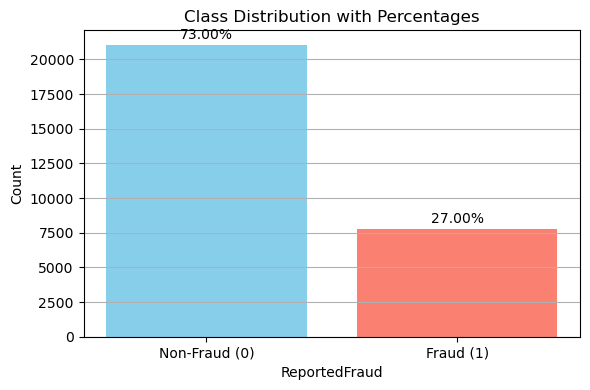

In [22]:

# Class distribution (already mapped to 0/1)
class_counts = merged_df['ReportedFraud'].value_counts()
class_percentages = class_counts / class_counts.sum() * 100

# Bar plot
plt.figure(figsize=(6, 4))
bars = plt.bar(class_counts.index.astype(str), class_counts.values, color=['skyblue', 'salmon'])

# Add percentage labels on top of each bar
for bar, percentage in zip(bars, class_percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 200, f'{percentage:.2f}%', ha='center', va='bottom')

# Labels and styling
plt.title("Class Distribution with Percentages")
plt.xlabel("ReportedFraud")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Non-Fraud (0)", "Fraud (1)"])
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#### 📊 Class Imbalance Analysis

##### 🖼️ Visualization Summary

The bar plot below illustrates the distribution of the target variable `ReportedFraud`:

- **Non-Fraud (0):** 73%
- **Fraud (1):** 27%

Although the classes are not extremely imbalanced (e.g., 95/5), there is still a **moderate imbalance** between fraudulent and non-fraudulent claims.

---


##### 💡 Recommended Solutions

| Strategy                        | Description                                                                 |
|---------------------------------|-----------------------------------------------------------------------------|
| `class_weight='balanced'`       | Automatically adjusts the model’s loss to give more importance to the minority class |
| **Stratified Cross-Validation** | Ensures each fold maintains the original class distribution during model evaluation |
| **Precision-Recall Evaluation** | Use metrics like precision, recall, F1-score, and AUC-PR for fair evaluation |


These strategies help in building a model that treats fraud detection with proper attention, even with imbalanced data.


### 3.14 - Outlier Detetction
Will use **box-plot** strategy to visually see which all features have outliers 

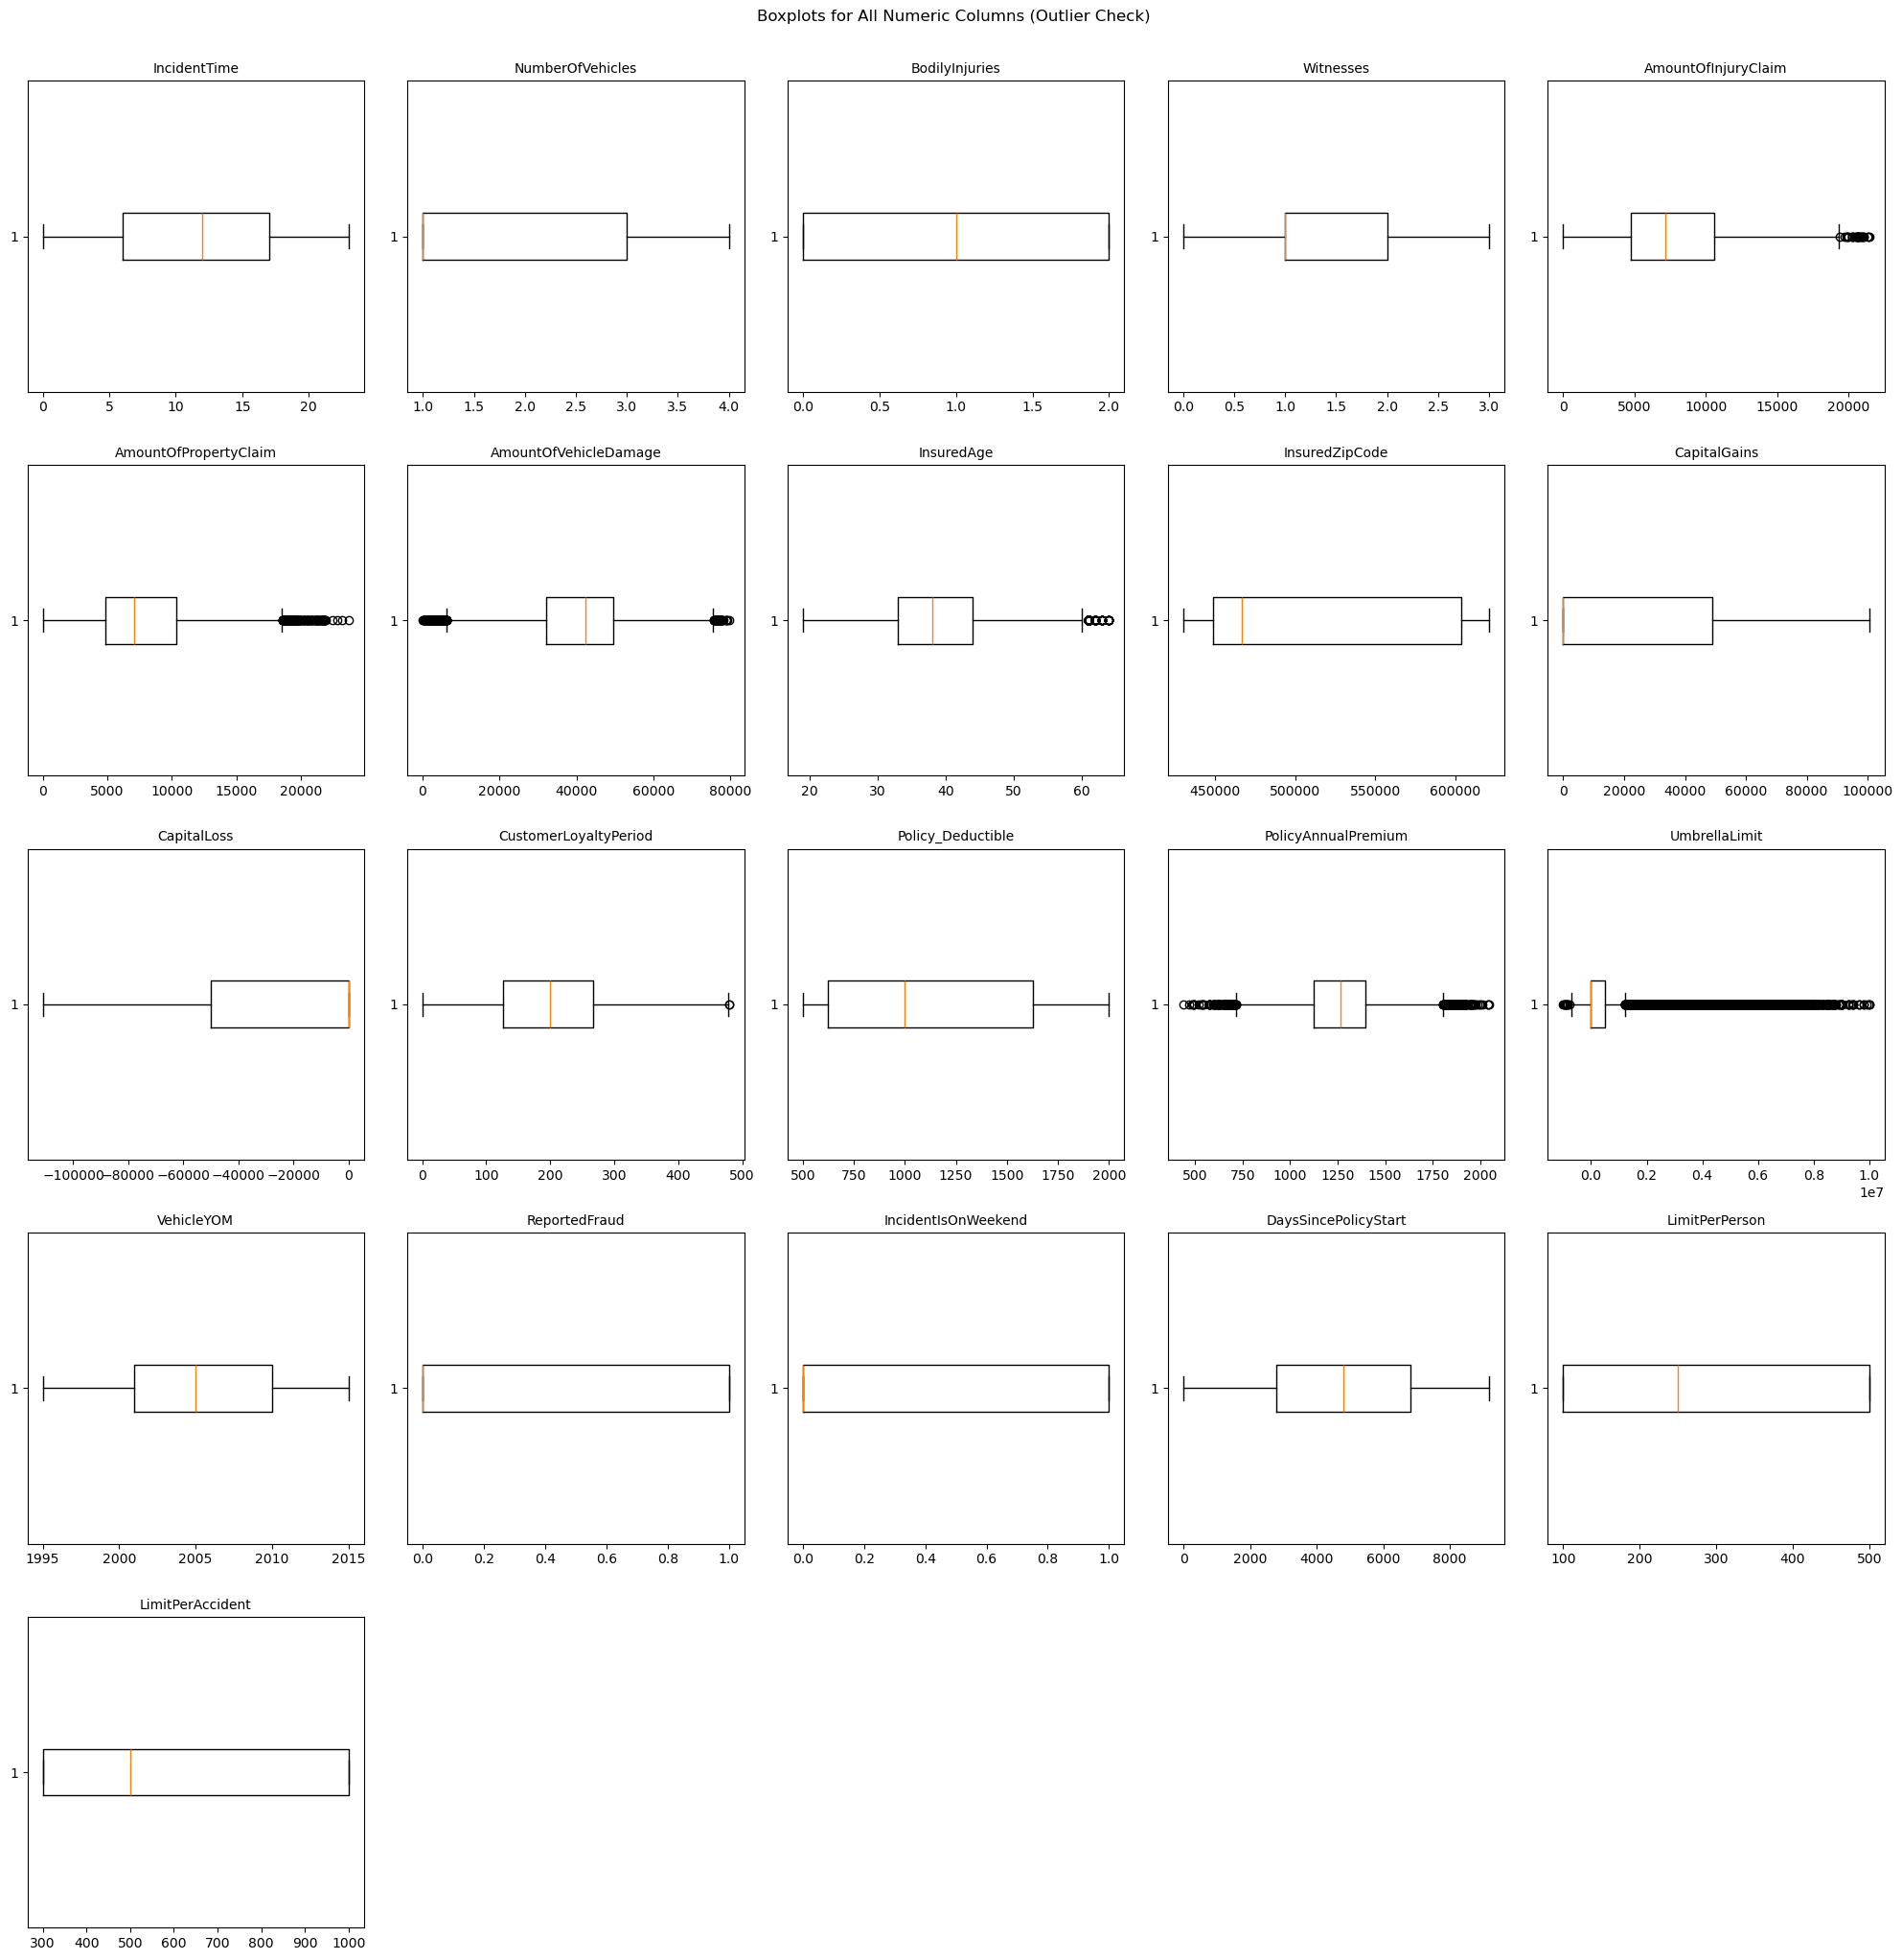

In [23]:
# Select numeric columns
numeric_cols = merged_df.select_dtypes(include=['float64','int64']).columns
n_cols = len(numeric_cols)

# Calculate grid dimensions (rows, cols)
n_rows = int(np.ceil(n_cols / 5))  # 5 columns per row (adjust as needed)
fig, axes = plt.subplots(n_rows, 5, figsize=(20, n_rows * 4))  # Adjust height per row
axes = axes.flatten()  # Flatten to 1D array for easy iteration

# Plot boxplots for each numeric column
for i, col in enumerate(numeric_cols):
    axes[i].boxplot(merged_df[col].dropna(), vert=False)
    axes[i].set_title(col, fontsize=10)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Boxplots for All Numeric Columns (Outlier Check)", y=1.02)
plt.show()

#### 📊 Outlier Summary Based on Box Plots (All Sets)

##### 🚨 Clear Outlier (Will Be Addressed):
- **UmbrellaLimit**: Contains values < 0 (logically invalid). These entries will be cleaned or removed.

##### ⚠️ Potential Outliers (Will Be Retained As-Is):
- **PolicyAnnualPremium**: Right-skewed with extreme high values.
- **CapitalGains**: Large upper-end values.
- **CapitalLoss**: Deep negative values; retained unless business rules say otherwise.
- **CustomerLoyaltyPeriod**: Some long-tenure customers; assumed valid.
- **AmountOfInjuryClaim**: Heavy right tail with dense outliers; kept for integrity.
- **AmountOfPropertyClaim**: Similar right-skew; retained.
- **AmountOfVehicleDamage**: Wide range and extreme values on both ends; retained.
- **InsuredAge**: Outliers at the high end (60+); assumed valid unless data says otherwise.

###### ✅ No Issues Observed (No Clear Outliers):
- **Policy_Deductible**
- **DaysSincePolicyStart**
- **ReportedFraud** (binary)
- **IncidentIsOnWeekend** (binary)
- **VehicleYOM**
- **IncidentTime**
- **NumberOfVehicles**
- **BodilyInjuries**
- **Witnesses**
- **InsuredZipCode**
- **LimitPerPerson**: Uniform spread, no points beyond whiskers.
- **LimitPerAccident**: Uniform spread, no points beyond whiskers.

##### 📝 Final Decision:
- Only **clear and logically invalid outliers** (e.g., `UmbrellaLimit < 0`) will be addressed.
- All other numerical outliers identified via box plots, including `LimitPerPerson` and `LimitPerAccident`, will be **retained** to preserve real-world variance and avoid over-cleaning.



In [24]:
negative_umbrella_mask = merged_df['UmbrellaLimit'] < 0
print(f"Found {negative_umbrella_mask.sum()} rows with negative UmbrellaLimit to be dropped")
merged_df = merged_df[~negative_umbrella_mask]

Found 34 rows with negative UmbrellaLimit to be dropped


### 3.15 -  Rescaling the attributes
#### Plot Numeric Feature Distributions (Histograms) to infer Scalaing Strategy

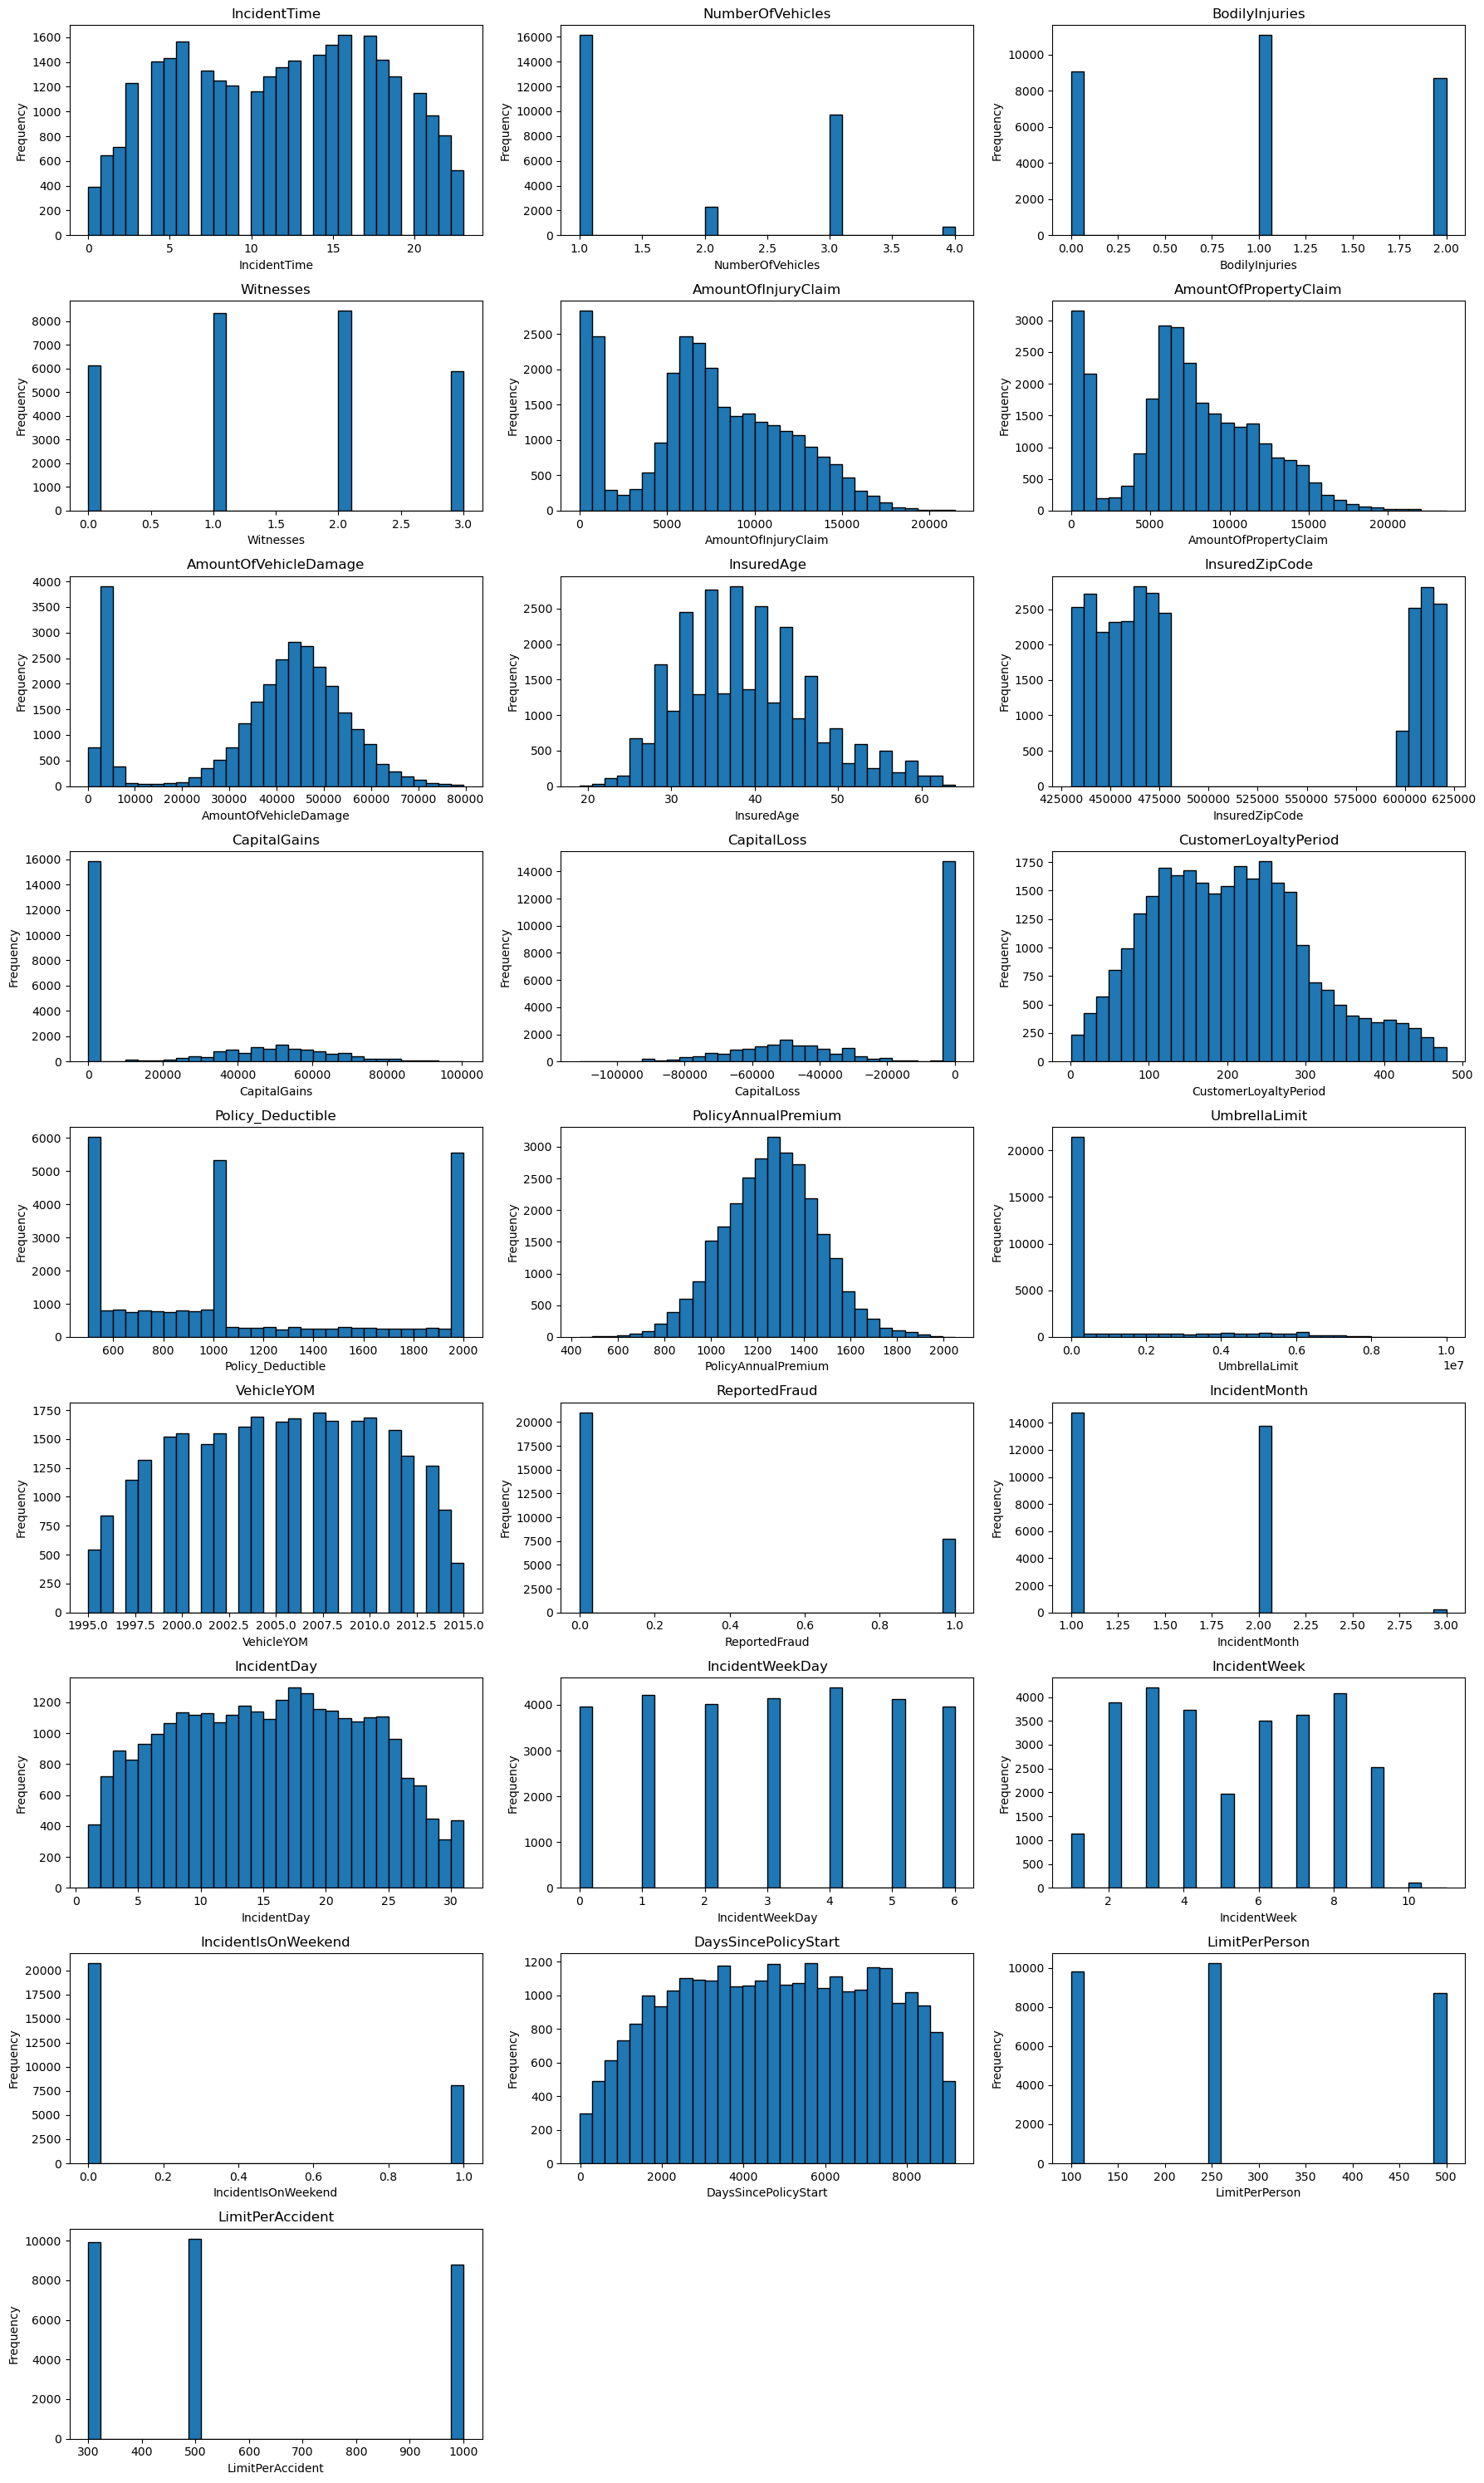

In [25]:

# Select numeric columns only
numeric_columns = merged_df.select_dtypes(include=['int64', 'float64', 'Int64', 'UInt32', 'int32']).columns

fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(18, 30))  # Adjust size as needed
axes = axes.flatten()

# Plot histogram for each numeric column
for i, col in enumerate(numeric_columns):
    axes[i].hist(merged_df[col].dropna(), bins=30, edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_ylabel("Frequency")
    axes[i].set_xlabel(col)

# Remove any extra empty plots (if less than 27)
for j in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



#### ⚙️ Feature Scaling Strategy

To ensure consistent model performance and interpretability, numeric features are scaled based on their nature using the following rules:

---


#### ✅ 1. High-Cardinality / Continuous Features → Use `StandardScaler`

These features have wide numeric ranges and many unique values. Standardization helps center and scale them.

| Feature                    | Unique Values |
|----------------------------|----------------|
| `InsurancePolicyNumber`    | 28836          |
| `PolicyAnnualPremium`      | 23852          |
| `AmountOfVehicleDamage`    | 20041          |
| `AmountOfInjuryClaim`      | 11958          |
| `AmountOfPropertyClaim`    | 11785          |
| `DaysSincePolicyStart`     | 7358           |
| `UmbrellaLimit`            | 7089           |
| `Policy_Deductible`        | 1496           |
| `InsuredZipCode`           | 995            |
| `CustomerLoyaltyPeriod`    | 479            |
| `CapitalLoss`              | 354            |
| `CapitalGains`             | 338            |


---

#### 🌗 2. Medium-Cardinality / Bounded Features → Use `MinMaxScaler`

These features are bounded and ordinal but not fully continuous. MinMax scaling preserves range and order.

| Feature              | Unique Values |
|----------------------|----------------|
| `IncidentDay`        | 31             |
| `IncidentTime`       | 25             |
| `VehicleYOM`         | 21             |
| `IncidentWeek`       | 11             |
| `InsuredAge`         | 46             |


---

#### 🚫 3. Low-Cardinality Integer Features (< 10 unique values) → Leave As-Is

Skip scaling for features that:
- Have **very few unique values**
- Are effectively discrete categories or count indicators


| Feature                 | Unique Values |
|-------------------------|----------------|
| `IncidentWeekDay`       | 7              |
| `Witnesses`             | 5              |
| `NumberOfVehicles`      | 4              |
| `IncidentMonth`         | 3              |
| `BodilyInjuries`        | 3              |
| `LimitPerPerson`        | 3              |
| `LimitPerAccident`      | 3              |
| `IncidentIsOnWeekend`   | 2              |



> These features can be optionally treated as categorical and one-hot encoded, depending on model sensitivity.

---
#### 🧠 Summary of Scaling Strategy

- **StandardScaler** → For continuous, high-cardinality numeric features  
- **MinMaxScaler** → For bounded, ordinal-like features  
- **Leave As-Is** → For low-cardinality (≤10) features — possibly treat as categorical

---





### 3.16 - 🧼 Missing Value Handling Strategy

This section outlines the strategy used for imputing missing values across different types of features prior to modeling with Logistic Regression.

---

##### ✅ 1. High-Cardinality / Continuous Features → `StandardScaler`

These features have wide ranges and many unique values. They are typically numeric and continuous.

**Imputation Strategy**:  
- `SimpleImputer(strategy='mean')`

**Reason**:  
- The mean preserves the central tendency for normally distributed features.
- Compatible with standardization which centers and scales data.

**Columns**:
- `PolicyAnnualPremium`
- `AmountOfVehicleDamage`
- `AmountOfInjuryClaim`
- `AmountOfPropertyClaim`
- `DaysSincePolicyStart`
- `UmbrellaLimit`
- `Policy_Deductible`
- `InsuredZipCode`
- `CustomerLoyaltyPeriod`
- `CapitalLoss`
- `CapitalGains`

---

##### ✅ 2. Bounded / Mid-Cardinality Features → `MinMaxScaler`

These are typically bounded or ordinal numerical features with moderate variability.

**Imputation Strategy**:  
- `SimpleImputer(strategy='median')`

**Reason**:  
- Median is robust to skewed distributions and outliers.
- MinMaxScaler is sensitive to outliers, so median ensures stable range.

**Columns**:
- `IncidentDay`
- `IncidentTime`
- `VehicleYOM`
- `IncidentWeek`
- `InsuredAge`

---

##### ✅ 3. Low-Cardinality / Count or Flag Features → Leave Unscaled

These are discrete, count-based, or binary features.

**Imputation Strategy**:  
- `SimpleImputer(strategy='most_frequent')`  


**Reason**:  
- These features often represent "presence" or "absence" of an event.
- Most frequent value is appropriate for small-range integer features.

**Columns**:
- `IncidentWeekDay`
- `Witnesses`
- `NumberOfVehicles`
- `IncidentMonth`
- `BodilyInjuries`
- `LimitPerPerson`
- `LimitPerAccident`
- `IncidentIsOnWeekend`

---

##### ✅ Categorical Columns (One-Hot Encoded)

Categorical features are handled separately using `OneHotEncoder`.

**Imputation Strategy**:  
- Imputation with `most_frequent` or `constant='missing'` can be optionally applied **before encoding**.

**Encoding Strategy**:  
- `OneHotEncoder(handle_unknown='ignore', sparse_output=False)`

---

##### 🔁 Summary Table

| Feature Group                | Scaler         | Imputer Strategy             |
|-----------------------------|----------------|------------------------------|
| Continuous (high-cardinality) | StandardScaler | Mean                         |
| Bounded/ordinal              | MinMaxScaler   | Median                       |
| Counts, flags (low cardinality) | None         | Most Frequent / Constant(0)  |
| Categorical (object type)    | OneHotEncoder  | Most Frequent / Constant     |


In [26]:

# 1. StandardScaler for high-cardinality / continuous features
standard_scale_cols = [
    'PolicyAnnualPremium', 'AmountOfVehicleDamage',
    'AmountOfInjuryClaim', 'AmountOfPropertyClaim', 'DaysSincePolicyStart',
    'UmbrellaLimit', 'Policy_Deductible', 'InsuredZipCode',
    'CustomerLoyaltyPeriod', 'CapitalLoss', 'CapitalGains'
]


# 2. MinMaxScaler for bounded or mid-cardinality features
minmax_scale_cols = [
    'IncidentDay', 'IncidentTime', 'VehicleYOM',
    'IncidentWeek', 'InsuredAge'
]

# 3. Leave these features unscaled (either categorical or simple counts)
leave_unchanged_cols = [
    'IncidentWeekDay', 'Witnesses', 'NumberOfVehicles',
    'IncidentMonth', 'BodilyInjuries',
    'LimitPerPerson', 'LimitPerAccident',
    'IncidentIsOnWeekend'
]

# 4. Leave these features unscaled (either categorical or simple counts)
onehot_encode_cols = [
    'InsuredGender',
    'InsuredEducationLevel',
    'InsuredOccupation',
    'InsuredHobbies',
    'InsurancePolicyState',
    'InsuredRelationship',
    'AuthoritiesContacted',
    'TypeOfIncident',
    'TypeOfCollission',
    'SeverityOfIncident',
    'IncidentState',
    'IncidentCity',
    'VehicleMake',
    'VehicleModel',
    'PropertyDamage',
    'PoliceReport',
]

target_col = ['ReportedFraud']


### Define target and features

In [27]:
# STEP 1: Define target and features
X = merged_df.drop(columns=['ReportedFraud'])
y = merged_df['ReportedFraud']


### 4 💼 Business Logic: Estimating Model-Driven Loss

#### 🎯 Goal
Quantify financial impact of a fraud detection model by translating prediction outcomes into **business costs and savings**.

---

#### 🧠 Core Logic

- **Fraud Rate Assumption**  
  Assume 10% of total customers file claims → helps infer total customer base from known fraud cases.

- **Claim & Profit Model**  
  - Each fraud costs: `average_claim`
  - Business aims for: **2× gross profit** over total fraud value.

- **Pricing Strategy**  
  Price per customer = `(Required Gross Profit) / (Total Customers)`  
  Ensures sustainable margins.

---

#### 💰 Financial Impact per Prediction Type

| Prediction | Business Effect |
|------------|-----------------|
| ✅ True Positive (TP) | Fraud caught → save `average_claim` |
| ❌ False Negative (FN) | Fraud missed → lose `average_claim` |
| ⚠️ False Positive (FP) | Good customer flagged → lose `price_per_policy` |
| ✅ True Negative (TN) | No effect |

---

#### 🧾 Final Formulae

- **Total Claims Value** = `fraud_cases × average_claim`  
- **Required Profit** = `2 × total_claims_value`  
- **Cost of FN** = `FN × average_claim`  
- **Cost of FP** = `FP × price_per_policy`  
- **Savings from TP** = `TP × average_claim`  
- **Net Impact** = `Savings - (Cost_FN + Cost_FP)`

---

#### ✅ Decision Logic

If `net_impact > 0`:  
→ **Model is financially beneficial**  
Else:  
→ **Model is financially detrimental**

---



In [28]:
# Average Claim
def compute_avg_claim(df, claim_cols=['AmountOfInjuryClaim', 'AmountOfPropertyClaim', 'AmountOfVehicleDamage']):
    """
    Computes average total claim amount across selected claim columns.

    Parameters:
    - df: DataFrame containing the claim columns
    - claim_cols: List of columns representing parts of a total claim

    Returns:
    - avg_claim (float): Mean of total claims across rows
    """
    df = df.copy()
    df['total_claim'] = df[claim_cols].sum(axis=1)
    return df['total_claim'].mean()

    
average_claim, number_of_claimants = compute_avg_claim(merged_df) , len(merged_df)  # full fraud data
average_claim ,number_of_claimants 

(np.float64(52268.720956877994), 28802)

**Estimated**  **`avg_claim = 52,268.72`**,  Total Fraud Cases **`number_of_claimants = 28,802`** using the fraud-only dataset.



In [29]:
def estimate_business_loss(false_negatives, false_positives, true_positives,
                         average_claim=52268.72, 
                         total_fraud_cases=28802, 
                         fraud_rate=0.1):
    """
    
    Analyzes insurance claim data to quantify the financial impact of a fraud detection model.
    
        Args:
            file_path (str): The path to the insurance claims CSV file.
            true_positives (int): Number of correctly identified fraudulent claims.
            false_negatives (int): Number of fraudulent claims missed by the model.
            false_positives (int): Number of legitimate claims wrongly flagged as fraud.
            true_negatives (int): Number of correctly identified legitimate claims.
    
        Returns:
            dict: A dictionary containing the detailed financial analysis results.
                  Returns None if the data file cannot be found.
    """



    # 2. Build the Pricing Model
    # Assumption: The cleaned dataset represents the customers who made a claim.
    number_of_claimants = total_fraud_cases
    
    # Assumption: 10% of the customer base files a claim.
    # From this, we can estimate the total number of customers.
    total_customers = number_of_claimants / 0.10
    
    # Calculate total value of all claims
    total_claims_value = number_of_claimants * average_claim
    
    # Calculate required gross profit (double the claims to cover overhead and profit)
    required_gross_profit = 2 * total_claims_value
    
    # Calculate the necessary price per policy
    price_per_policy = required_gross_profit / total_customers
    
    
    # 3. Calculate the Financial Impact of the Model's Errors
    
    # Cost of False Positives: Legitimate customers are wrongly flagged.
    # We assume these customers are lost, costing one year's premium.
    cost_of_fp = false_positives * price_per_policy
    
    # Cost of False Negatives: Fraudulent claims that the model missed.
    # This is the direct cost of paying out these fraudulent claims.
    cost_of_fn = false_negatives * average_claim
    
    # Savings from True Positives: Fraudulent claims correctly identified.
    # This is the direct savings from not paying out these claims.
    savings_from_tp = true_positives * average_claim
    
    # Net Financial Impact of the Model
    net_impact = savings_from_tp - cost_of_fn - cost_of_fp

    
    # --- 4. Package Results into a Dictionary ---
    results = {
        'required_gross_profit': required_gross_profit,
        'price_per_policy': price_per_policy,
        'savings_from_tp': savings_from_tp,
        'cost_of_fn': cost_of_fn,
        'cost_of_fp': cost_of_fp,
        'net_impact': net_impact,
        'is_beneficial': net_impact > 0
    } 

    return results
    


### 5 -  Pipeline Preprocessing Utility Class & Functions

#### 5.1 📉 Class to drop highly correlated numerical features (|r| > 0.9) during training to prevent multicollinearity and data leakage in downstream models.

In [30]:
# Class to find which features are highly corelated and can be dropped i.e threshold > 0.9
class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.columns_to_drop_ = []

    def fit(self, X, y=None):
        numeric_df = X.select_dtypes(include=['number'])
        corr_matrix = numeric_df.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        # For each column in the upper triangle, if any value in that column exceeds the threshold, it marks that column for removal.
        self.columns_to_drop_ = [column for column in upper.columns if any(upper[column] > self.threshold)]
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_drop_, errors='ignore')



#### 5.2 Utility function for Generating Learning ,Precision-Recall, ROC Curve and BER ( Balance Error Curve)

In [31]:

def plot_model_curves(pipeline, X_train, y_train, X_test, y_test, title_prefix="Fraud Classifier"):
    # Set consistent style
    plt.style.use('seaborn-v0_8')
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.3

    # ---- 1️⃣ Learning Curve ----
    train_sizes, train_scores, val_scores = learning_curve(
        estimator=pipeline,
        X=X_train,
        y=y_train,
        cv=StratifiedKFold(5),
        scoring='f1',
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1,
        random_state=42
    )

    # ---- 2️⃣ Get Predictions ----
    pipeline.fit(X_train, y_train)
    y_probs = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate optimal threshold based on F1-score
    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = pr_thresholds[optimal_idx]
    y_pred = (y_probs >= optimal_threshold).astype(int)

    # ---- 3️⃣ Calculate All Metrics ----
    # Precision-Recall
    ap_score = average_precision_score(y_test, y_probs)
    
    # ROC Curve
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_probs)
    roc_auc = roc_auc_score(y_test, y_probs)
    
    # BER Curve
    thresholds = np.linspace(0, 1, 100)
    ber_scores = []
    for thresh in thresholds:
        y_pred_temp = (y_probs >= thresh).astype(int)
        ber = 1 - balanced_accuracy_score(y_test, y_pred_temp)
        ber_scores.append(ber)
    optimal_ber_idx = np.argmin(ber_scores)
    optimal_ber_threshold = thresholds[optimal_ber_idx]
    min_ber = ber_scores[optimal_ber_idx]
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # ---- 📊 Plot All Visualizations ----
    fig = plt.figure(figsize=(12, 6))
    gs = fig.add_gridspec(2, 3)
    
    # 1. Learning Curve
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(train_sizes, train_scores.mean(1), 'o-', color='#1f77b4', label='Training F1')
    ax1.fill_between(train_sizes, 
                   train_scores.mean(1) - train_scores.std(1),
                   train_scores.mean(1) + train_scores.std(1),
                   alpha=0.1, color='#1f77b4')
    ax1.plot(train_sizes, val_scores.mean(1), 'o-', color='#ff7f0e', label='Validation F1')
    ax1.fill_between(train_sizes,
                   val_scores.mean(1) - val_scores.std(1),
                   val_scores.mean(1) + val_scores.std(1),
                   alpha=0.1, color='#ff7f0e')
    ax1.set_title(f'Learning Curve\n({title_prefix})', pad=12)
    ax1.set_xlabel('Training Samples')
    ax1.set_ylabel('F1 Score')
    ax1.legend(loc='lower right')

    # 2. Precision-Recall Curve
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(recall, precision, color='#2ca02c', label=f'AP = {ap_score:.3f}')
    ax2.axhline(y=(y_test.mean()), color='r', linestyle='--', label='Baseline (Random)')
    ax2.set_title(f'Precision-Recall Curve\n({title_prefix})', pad=12)
    ax2.set_xlabel('Recall (Sensitivity)')
    ax2.set_ylabel('Precision (PPV)')
    ax2.legend(loc='upper right')

    # 3. ROC Curve
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(fpr, tpr, color='#9467bd', label=f'AUC = {roc_auc:.3f}')
    ax3.plot([0, 1], [0, 1], 'r--', label='Baseline (Random)')
    ax3.set_title(f'ROC Curve\n({title_prefix})', pad=12)
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.legend(loc='lower right')

    # 4. BER Curve
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.plot(thresholds, ber_scores, color='#d62728', label='BER Curve')
    ax4.scatter(optimal_ber_threshold, min_ber, color='red', 
              label=f'Optimal: {optimal_ber_threshold:.2f}\nMin BER: {min_ber:.3f}')
    ax4.set_title(f'Balanced Error Rate Curve\n({title_prefix})', pad=12)
    ax4.set_xlabel('Threshold')
    ax4.set_ylabel('Balanced Error Rate')
    ax4.legend(loc='upper right')

    # 5. Confusion Matrix (Counts)
    ax5 = fig.add_subplot(gs[1, 1:])  # Span full width for confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=['Legit', 'Fraud'])
    disp.plot(ax=ax5, cmap='Blues', values_format='d', colorbar=False)
    ax5.set_title(f'Confusion Matrix (Threshold: {optimal_threshold:.3f})', pad=12)

    plt.tight_layout()
    plt.show()

    # ---- 🎯 Optimal Threshold Analysis ----
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n{' Optimal Threshold Analysis ':-^60}")
    print(f"\nBased on F1-Score: {optimal_threshold:.4f}")
    print(f"Max F1-Score: {f1_scores[optimal_idx]:.4f}")
    print(f"- Precision = {precision[optimal_idx]:.4f}")
    print(f"- Recall = {recall[optimal_idx]:.4f}")
    
    print(f"\nBased on BER: {optimal_ber_threshold:.4f}")
    print(f"Min Balanced Error Rate: {min_ber:.4f}")
    
    print(f"\n{' Confusion Matrix Metrics ':-^60}")
    print(f"\nAt threshold: {optimal_threshold:.4f}")
    print(f"True Positives (TP): {tp}")
    print(f"False Positives (FP): {fp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Negatives (FN): {fn}")
    
    print(f"\nAdditional Metrics:")
    print(f"Accuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
    print(f"Specificity (TNR): {tn / (tn + fp):.4f}")
    print(f"False Positive Rate: {fp / (fp + tn):.4f}")

    # Business impact
    analysis_results = estimate_business_loss(fn, fp , tp)
    
    # Print business cost summary
    print(f"\n{' Business Impact Estimation ':-^60}")
    print("\n--- Pricing Model ---")
    
    print(f"Required Gross Profit: {human_readable_currency(analysis_results['required_gross_profit'])}")
    print(f"Required Price per Policy: {human_readable_currency(analysis_results['price_per_policy'])}")
    
    print("\n--- Model Financial Impact Analysis ---")
    print(f"Savings from catching fraud (True Positives): {human_readable_currency(analysis_results['savings_from_tp'])}")
    print(f"Cost of missing fraud (False Negatives): {human_readable_currency(analysis_results['cost_of_fn'])}")
    print(f"Cost of losing customers (False Positives): {human_readable_currency(analysis_results['cost_of_fp'])}")
    print("-------------------------------------------------")
    print(f"Net Financial Impact of the Model: {human_readable_currency(analysis_results['net_impact'])}")
    print("-------------------------------------------------")
    
    if analysis_results['is_beneficial']:
        print("\nConclusion: ✅ The model is financially beneficial.")
    else:
        print("\nConclusion: ❌ The model is financially detrimental.")

def human_readable_currency(amount):
    """
    Formats large currency numbers into human-friendly strings.
    E.g., 24,409,492 → $24.4M
    """
    if amount >= 1_000_000_000:
        return f"${amount/1_000_000_000:.1f}B"
    elif amount >= 1_000_000:
        return f"${amount/1_000_000:.1f}M"
    elif amount >= 1_000:
        return f"${amount/1_000:.1f}K"
    else:
        return f"${amount:,.0f}"        

#### 5.3 Utility Function for creating pre-process-pipeline

In [32]:
def prepare_data_pipeline(X, y, standard_scale_cols, minmax_scale_cols, 
                          leave_unchanged_cols, onehot_encode_cols, 
                          correlation_threshold=0.9, test_size=0.2, random_state=42):
    """
    Splits the data, applies correlation filtering, and returns:
    - updated X_train, X_test, y_train, y_test
    - fitted correlation filter
    - updated column lists
    - ColumnTransformer preprocessor
    """
    # STEP 1: Split the dataset with stratification as class is imbalance
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=test_size, random_state=random_state
    )

    # STEP 2: Apply correlation filter on training data
    corr_filter = CorrelationFilter(threshold=correlation_threshold)
    X_corr_filtered = corr_filter.fit_transform(X_train)

    columns_dropped = corr_filter.columns_to_drop_
    print("Correlated Columns Dropped:", columns_dropped)

    # STEP 3: Rebuild feature column groups after drop
    standard_scale_cols = [col for col in standard_scale_cols if col not in columns_dropped]
    minmax_scale_cols = [col for col in minmax_scale_cols if col not in columns_dropped]
    leave_unchanged_cols = [col for col in leave_unchanged_cols if col not in columns_dropped]
    onehot_encode_cols = [col for col in onehot_encode_cols if col not in columns_dropped]

    # STEP 4: Define imputers and scalers
    standard_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='mean')),
        ('scale', StandardScaler())
    ])

    minmax_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', MinMaxScaler())
    ])

    unchanged_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent'))
    ])

    # STEP 5: Define column transformer
    preprocessor = ColumnTransformer([
        ('standard', standard_pipeline, standard_scale_cols),
        ('minmax', minmax_pipeline, minmax_scale_cols),
        ('unchanged', unchanged_pipeline, leave_unchanged_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), onehot_encode_cols)
    ], remainder='drop')

    return (X_train, X_test, y_train, y_test, preprocessor)


#### 5.4 Split Data and apply Corelation and get ColumnTransformer

In [33]:
X_train, X_test, y_train, y_test, preprocessor = prepare_data_pipeline(
    X, y,
    standard_scale_cols,
    minmax_scale_cols,
    leave_unchanged_cols,
    onehot_encode_cols
)


Correlated Columns Dropped: ['CustomerLoyaltyPeriod']


#### Outcome of above execution is ``CustomerLoyaltyPeriod`` is **dropped** as its corelation is greater than threashhold which is 0.9

## 4 - Technique 1 - **Logistic Regrssion**

### 🎯 Motivation for Choosing Logistic Regression

Logistic Regression (LR) was selected as the first classification technique due to its strong alignment with both technical and business requirements of the client. It is a fast, transparent, and interpretable model that outputs **calibrated probabilities** — a key requirement for optimizing **business cost** via threshold tuning.

Key reasons for selection:

- **Interpretability**: Model coefficients are easy to explain to stakeholders.
- **Efficiency**: Quick to train and validate.
- **Probabilistic Output**: Allows threshold-based control for cost sensitivity.
- **Business Alignment**: Supports calculating cost/savings per TP, FP, FN.
- **Resilience**: Regularization (`C=0.1`) improves generalization.
- **Class Imbalance Ready**: Built-in support with `class_weight='balanced'`.

This technique serves as a **baseline reference model** that is business-aware, technically sound, and benchmarked against cost-sensitive performance objectives.

---

### 🧪 Schematic of the Analysis Process

```mermaid
graph TD
    A[Cleansed Data] --> B[Stratified Train-Test Split]
    B --> C[Correlation Filtering - Train Only]
    C --> D[Drop Correlated Columns and Regroup Features]
    D --> E[Define Column Pipelines - Impute and Scale]
    E --> F[ColumnTransformer for Full Preprocessing]

    %% Branch 1: Base Logistic Regression
    F --> G1["Logistic Regression - No Tuning (Baseline Version)"]
    G1 --> H1[Evaluate: ROC, PR, Confusion Matrix, BER]
    H1 --> I1[Estimate Business Impact]
    I1 --> J1[Savings from TP = TP × avg_claim]
    I1 --> J2[Cost from FN = FN × avg_claim]
    I1 --> J3[Cost from FP = FP × price_per_policy]

    %% Branch 2: Tuned Logistic Regression
    F --> G2[GridSearchCV with Stratified K-Fold]
    G2 --> H2[Logistic Regression with Regularization C=0.1]
    H2 --> I2[Evaluate: ROC, PR, Confusion Matrix, BER]
    I2 --> K1[Estimate Business Impact]
    K1 --> L1[Savings from TP = TP × avg_claim]
    K1 --> L2[Cost from FN = FN × avg_claim]
    K1 --> L3[Cost from FP = FP × price_per_policy]
```


### 4.1  Baseline version of LogisticRegression

In [71]:
# Final Combined pipeline
pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(
        class_weight='balanced',
        penalty='l2',
        C=0.1, # More regularization
        solver='liblinear',
        max_iter=1000
    ))
])

# Fit and Evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

y_probs = pipeline.predict_proba(X_test)[:, 1]
print(f"AP Score: {average_precision_score(y_test, y_probs):.3f}")




              precision    recall  f1-score   support

           0       0.90      0.83      0.86      4205
           1       0.62      0.76      0.68      1556

    accuracy                           0.81      5761
   macro avg       0.76      0.79      0.77      5761
weighted avg       0.83      0.81      0.82      5761

AP Score: 0.725


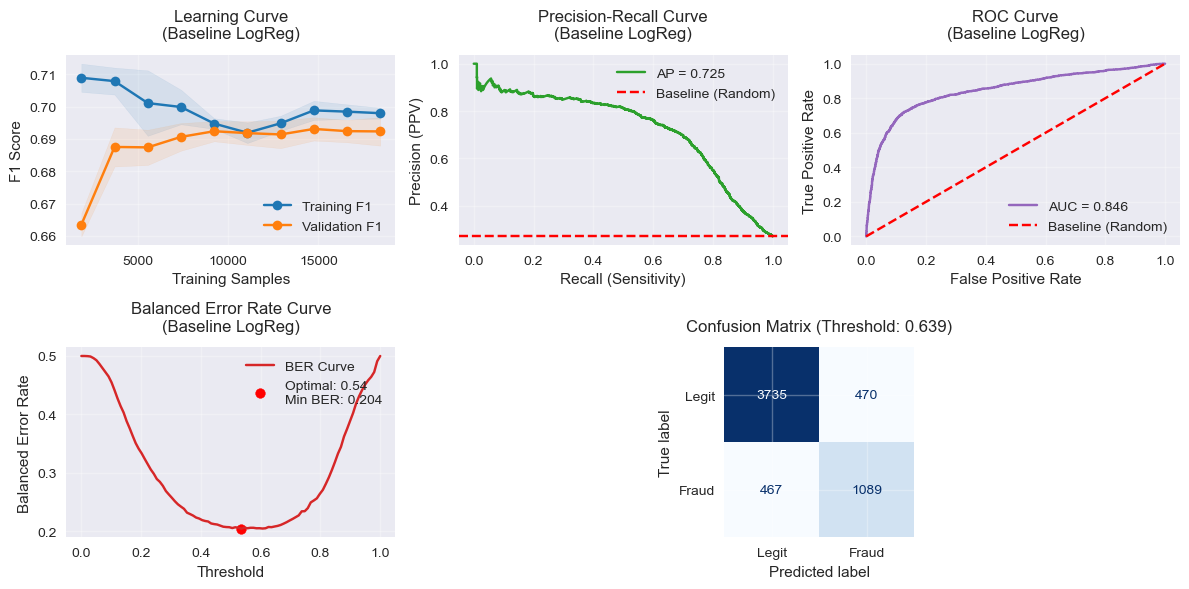


---------------- Optimal Threshold Analysis ----------------

Based on F1-Score: 0.6391
Max F1-Score: 0.6992
- Precision = 0.6985
- Recall = 0.6999

Based on BER: 0.5354
Min Balanced Error Rate: 0.2040

----------------- Confusion Matrix Metrics -----------------

At threshold: 0.6391
True Positives (TP): 1089
False Positives (FP): 470
True Negatives (TN): 3735
False Negatives (FN): 467

Additional Metrics:
Accuracy: 0.8374
Balanced Accuracy: 0.7940
Specificity (TNR): 0.8882
False Positive Rate: 0.1118

---------------- Business Impact Estimation ----------------

--- Pricing Model ---
Required Gross Profit: $3.0B
Required Price per Policy: $10.5K

--- Model Financial Impact Analysis ---
Savings from catching fraud (True Positives): $56.9M
Cost of missing fraud (False Negatives): $24.4M
Cost of losing customers (False Positives): $4.9M
-------------------------------------------------
Net Financial Impact of the Model: $27.6M
-------------------------------------------------

Conclusi

In [103]:
plot_model_curves(pipeline, X_train, y_train, X_test, y_test, title_prefix="Baseline-LogReg")

#### 📊 Brief Evaluation Summary (Baseline Logistic Regression)

- **Learning Curve**  
  Training and validation F1 scores are close, indicating low variance. The model does not appear to overfit significantly.

- **Precision-Recall Curve**  
  Precision remains above baseline across most recall values. Area under the curve (AP = 0.725) shows good performance for the imbalanced dataset.

- **ROC Curve**  
  AUC = 0.846 indicates strong separability between fraud and legitimate claims. The model performs significantly better than random guessing.

- **Balanced Error Rate (BER) Curve**  
  Minimum BER of 0.204 is achieved at threshold ≈ 0.5, supporting the client's target of minimizing false positive and false negative rates.

- **Confusion Matrix**  
  At the optimal threshold of 0.639:
  - TP = 1089, FP = 470  
  - TN = 3735, FN = 467

- **Threshold Metrics Summary**  
  - Precision: 0.6985  
  - Recall: 0.6999  
  - F1 Score: 0.6992  
  - Accuracy: 0.8374  
  - Balanced Accuracy: 0.7940

- **Business Impact Analysis**  
  - Savings from TP: **$56.9M**  
  - Cost of FN: **$24.4M**  
  - Cost of FP: **$4.9M**  
  - **Net Financial Impact**: **$27.6M**

✅ **Conclusion**: The model is **financially beneficial** and technically balanced, meeting performance goals in both BER and business impact.


### 4.2 -  Hyperparameter Tuning with Stratified K-Fold + GridSearchCV

In [104]:

# 1. Define a targeted parameter grid
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100,1000,10000],  # Test Regularization [0.01, 0.1, 1, 10, 100]
    'clf__penalty': ['l2','l1'],           # Faster than l1 for liblinear
    'clf__solver': ['liblinear'],     # Optimized for small-to-medium datasets
    'clf__class_weight': ['balanced',{0:1, 1:5}] # Focus on best imbalance handling
}


# 2. Streamlined CV strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Reduced from 3-fold

# 3. Configure GridSearch
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='average_precision',  # Best metric for fraud detection
    cv=cv,
    n_jobs=-1,                   # Use all CPU cores
    verbose=1                    # Moderate verbosity
)

# 4. Execute with timing
print("Starting optimized GridSearch...")
start_time = time.time()
grid_search.fit(X_train, y_train)
print(f"GridSearch completed in {(time.time()-start_time)/60:.1f} minutes")

# 5. Best model analysis
lr_best_model_with_hyper_tunning = grid_search.best_estimator_
print("\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"{param:20}: {value}")

# 6. Final evaluation
y_pred = lr_best_model_with_hyper_tunning.predict(X_test)
y_probs = lr_best_model_with_hyper_tunning.predict_proba(X_test)[:, 1]
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred))
print(f"AP Score: {average_precision_score(y_test, y_probs):.3f}")


Starting optimized GridSearch...
Fitting 3 folds for each of 28 candidates, totalling 84 fits
GridSearch completed in 0.6 minutes

Best Parameters:
clf__C              : 100
clf__class_weight   : balanced
clf__penalty        : l2
clf__solver         : liblinear

Test Set Performance:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      4205
           1       0.62      0.76      0.68      1556

    accuracy                           0.81      5761
   macro avg       0.76      0.79      0.77      5761
weighted avg       0.83      0.81      0.82      5761

AP Score: 0.726


#### Plot Logistic Regression Learning ,Precision-Recall ,ROC Curve , BER , Confusion - StratifiedKFold and GridSearchCV

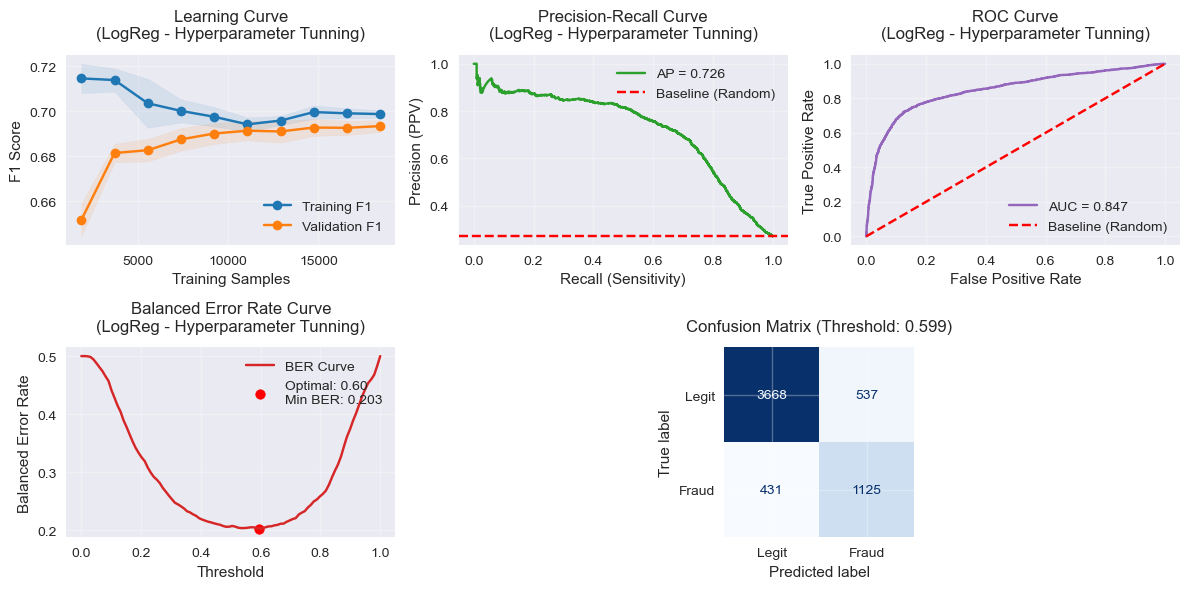


---------------- Optimal Threshold Analysis ----------------

Based on F1-Score: 0.5990
Max F1-Score: 0.6992
- Precision = 0.6769
- Recall = 0.7230

Based on BER: 0.5960
Min Balanced Error Rate: 0.2027

----------------- Confusion Matrix Metrics -----------------

At threshold: 0.5990
True Positives (TP): 1125
False Positives (FP): 537
True Negatives (TN): 3668
False Negatives (FN): 431

Additional Metrics:
Accuracy: 0.8320
Balanced Accuracy: 0.7977
Specificity (TNR): 0.8723
False Positive Rate: 0.1277

---------------- Business Impact Estimation ----------------

--- Pricing Model ---
Required Gross Profit: $3.0B
Required Price per Policy: $10.5K

--- Model Financial Impact Analysis ---
Savings from catching fraud (True Positives): $58.8M
Cost of missing fraud (False Negatives): $22.5M
Cost of losing customers (False Positives): $5.6M
-------------------------------------------------
Net Financial Impact of the Model: $30.7M
-------------------------------------------------

Conclusi

In [105]:

plot_model_curves(
    pipeline=lr_best_model_with_hyper_tunning,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    title_prefix="LogReg - Hyperparameter Tunning"
)

### 📊 Brief Evaluation Summary (Tuned Logistic Regression via GridSearchCV)

- **Learning Curve**  
  Training and validation F1 scores remain closely aligned, suggesting reduced overfitting and improved generalization after tuning.

- **Precision-Recall Curve**  
  AP = 0.726, slightly improved over the baseline. The model maintains high precision across a broad range of recall values.

- **ROC Curve**  
  AUC = 0.847 confirms strong discrimination capability, comparable to the baseline model.

- **Balanced Error Rate (BER) Curve**  
  Minimum BER of 0.2027 is achieved at threshold ≈ 0.6, showing slight improvement in balancing false positives and false negatives.

- **Confusion Matrix**  
  At the optimal threshold of 0.599:
  - TP = 1125, FP = 537  
  - TN = 3668, FN = 431

- **Threshold Metrics Summary**  
  - Precision: 0.6769  
  - Recall: 0.7230  
  - F1 Score: 0.6992  
  - Accuracy: 0.8320  
  - Balanced Accuracy: 0.7977

- **Business Impact Analysis**  
  - Savings from TP: **$58.8M**  
  - Cost of FN: **$22.5M**  
  - Cost of FP: **$5.6M**  
  - **Net Financial Impact**: **$30.7M**

✅ **Conclusion**: The tuned model is **financially beneficial** and shows slightly improved recall and business value over the baseline model.


## 5 - Technique 2 - **RandomForest**

### 🎯 Motivation for Choosing Random Forest

Random Forest (RF) is an ensemble learning technique known for its high performance and robustness, especially in **tabular data with mixed feature types**. It works by aggregating decisions from multiple decorrelated trees, making it resistant to overfitting and suitable for **imbalanced and noisy datasets** like fraud detection.

Key reasons for choosing Random Forest:

- **Handles Imbalanced Data**: Can integrate `class_weight='balanced'` natively.
- **Captures Nonlinear Interactions**: Unlike Logistic Regression, RF models complex interactions without needing feature engineering.
- **Robust to Overfitting**: Tree-level regularization (via `max_depth`, `min_samples_leaf`) helps improve generalization.
- **Feature Importance**: Useful for understanding which attributes contribute most to fraud detection.
- **Tunable for Business Constraints**: Through hyperparameters and thresholding, RF can be optimized for precision/recall trade-offs and cost minimization.

This model complements Logistic Regression by offering **greater flexibility** at the cost of some interpretability.

---

### 🧪 Schematic of the Analysis Process

```mermaid
graph TD
    A[Cleansed Data] --> B[Stratified Train-Test Split]
    B --> C[Correlation Filtering - Train Only]
    C --> D[Drop Correlated Columns and Regroup Features]
    D --> E[Define Column Pipelines - Impute and Scale]
    E --> F[ColumnTransformer for Full Preprocessing]

    %% Branch 1: Base Random Forest
    F --> G1[Random Forest - Base Model]
    G1 --> H1[Evaluate: ROC, PR, Confusion Matrix, BER]
    H1 --> I1[Estimate Business Impact]
    I1 --> J1[Savings from TP = TP × avg_claim]
    I1 --> J2[Cost from FN = FN × avg_claim]
    I1 --> J3[Cost from FP = FP × price_per_policy]

    %% Branch 2: Hyperparameter Tuning - Full Feature Set
    F --> G2[GridSearchCV - 168 Features]
    G2 --> H2[Best Tuned RF - Full Features]
    H2 --> I2[Evaluate: ROC, PR, Confusion Matrix, BER]
    I2 --> K1[Estimate Business Impact]
    K1 --> L1[Savings from TP = TP × avg_claim]
    K1 --> L2[Cost from FN = FN × avg_claim]
    K1 --> L3[Cost from FP = FP × price_per_policy]

    %% Branch 3: Hyperparameter Tuning - 100 Features
    F --> G3["GridSearchCV - 100 Top Features (Reduced)"]
    G3 --> H3[Best Tuned RF - Reduced Features]
    H3 --> I3[Evaluate: ROC, PR, Confusion Matrix, BER]
    I3 --> M1[Estimate Business Impact]
    M1 --> N1[Savings from TP = TP × avg_claim]
    M1 --> N2[Cost from FN = FN × avg_claim]
    M1 --> N3[Cost from FP = FP × price_per_policy]
```

### ⚙️ Summary of Model Implementation Steps

- **Base Model Configuration**  
  Used 100 trees (`n_estimators=100`) with moderately regularized settings:
  - `max_depth=None`, `min_samples_leaf=2`, `max_features='sqrt'`, and `class_weight='balanced'`

  This provided a strong baseline with out-of-box generalization.

- **Hyperparameter Tuning (Full Feature Set, 168 Features)**  
  Conducted extensive grid search using `StratifiedKFold` and a well-regularized parameter grid:
  - Tuned `max_depth`, `min_samples_split`, `min_samples_leaf`, `min_impurity_decrease`, etc.
  - Evaluation focused on recall, BER, and net financial impact

- **Re-Tuning with Feature Reduction (Top 100 Features)**  
  Performed feature reduction to address potential overfitting.
  - Repeated GridSearchCV on the reduced set.
  - However, **learning curves still showed a performance gap** between training and validation sets.

- **Overfitting Diagnosis**  
  Despite feature reduction, the gap between training and CV curves **persisted**, indicating that:
  - Overfitting is **not caused by high feature dimensionality**,  
  - But likely due to **limited training data**, causing high variance.

- **Performance Evaluation**  
  All three models (baseline, tuned-168, tuned-100) were evaluated using:
  - ROC/PR curves, BER, F1, Precision, Recall
  - Cost modeling based on TP, FP, FN business impact

### 5.1 - Baseline version of RandomForest

In [34]:

# Final Combined pipeline
pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42
    ))
])

# Fit and Evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

y_probs = pipeline.predict_proba(X_test)[:, 1]
print(f"AP Score: {average_precision_score(y_test, y_probs):.3f}")


              precision    recall  f1-score   support

           0       0.93      0.97      0.95      4205
           1       0.91      0.79      0.84      1556

    accuracy                           0.92      5761
   macro avg       0.92      0.88      0.90      5761
weighted avg       0.92      0.92      0.92      5761

AP Score: 0.866


### Learning and Precision Recall Curve & ROC

/opt/homebrew/Caskroom/miniconda/base/envs/.uol/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


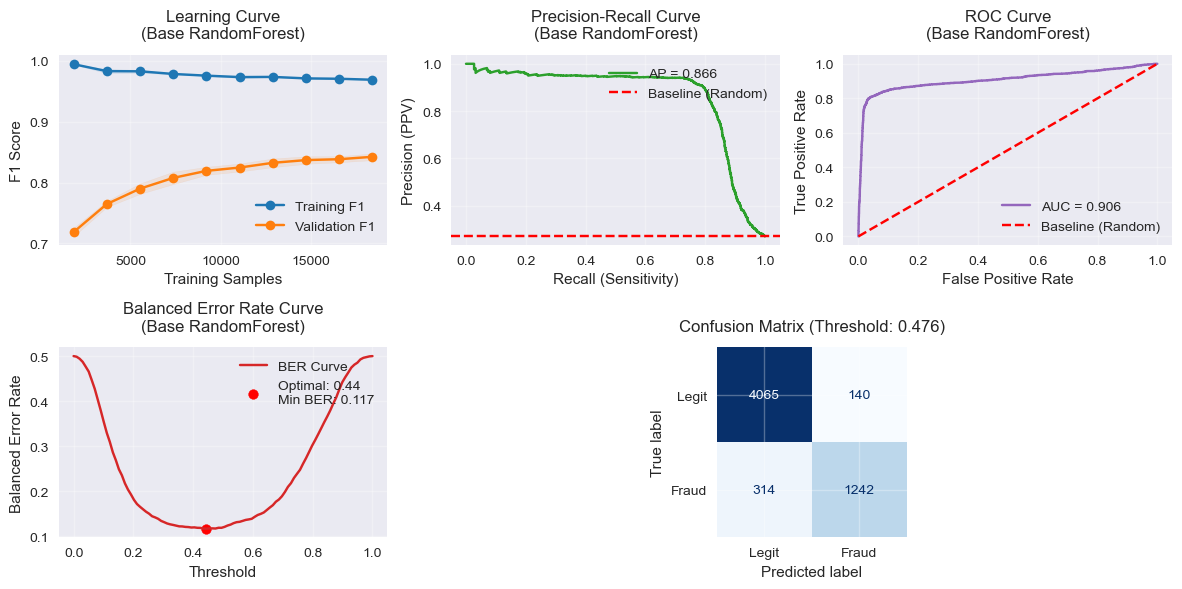


---------------- Optimal Threshold Analysis ----------------

Based on F1-Score: 0.4755
Max F1-Score: 0.8455
- Precision = 0.8987
- Recall = 0.7982

Based on BER: 0.4444
Min Balanced Error Rate: 0.1172

----------------- Confusion Matrix Metrics -----------------

At threshold: 0.4755
True Positives (TP): 1242
False Positives (FP): 140
True Negatives (TN): 4065
False Negatives (FN): 314

Additional Metrics:
Accuracy: 0.9212
Balanced Accuracy: 0.8825
Specificity (TNR): 0.9667
False Positive Rate: 0.0333

---------------- Business Impact Estimation ----------------

--- Pricing Model ---
Required Gross Profit: $3.0B
Required Price per Policy: $10.5K

--- Model Financial Impact Analysis ---
Savings from catching fraud (True Positives): $64.9M
Cost of missing fraud (False Negatives): $16.4M
Cost of losing customers (False Positives): $1.5M
-------------------------------------------------
Net Financial Impact of the Model: $47.0M
-------------------------------------------------

Conclusi

In [64]:

plot_model_curves(pipeline, X_train, y_train, X_test, y_test, title_prefix="Base RandomForest")


### 📊 Brief Evaluation Summary (Baseline Random Forest)

- **Learning Curve**  
  High training scores and a visible gap with validation scores suggest **mild overfitting**, but the validation curve steadily improves with more data.

- **Precision-Recall Curve**  
  AP = 0.866 — the highest among all models so far. The model maintains very high precision even at lower recall levels, which is beneficial for fraud detection.

- **ROC Curve**  
  AUC = 0.906, showing excellent discrimination between fraud and legitimate cases.

- **Balanced Error Rate (BER) Curve**  
  BER is minimized to 0.117 at a threshold of ~0.475 — significantly better than other models, indicating balanced predictive power.

- **Confusion Matrix**  
  At the optimal threshold of 0.475:
  - TP = 1242, FP = 140  
  - TN = 4065, FN = 314

- **Threshold Metrics Summary**  
  - Precision: 0.8987  
  - Recall: 0.7982  
  - F1 Score: 0.8455  
  - Accuracy: 0.9212  
  - Balanced Accuracy: 0.8825  
  - False Positive Rate: 0.0333

- **Business Impact Analysis**  
  - Savings from TP: **$64.9M**  
  - Cost of FN: **$16.4M**  
  - Cost of FP: **$1.5M**  
  - **Net Financial Impact**: **$47.0M**

✅ **Conclusion**: The model is **financially beneficial**, offering the **best BER and net profit** among all baseline models, with excellent precision and recall balance.


### Calculating Total Features

In [35]:
total_columns = (
    len(standard_scale_cols) +          # Standard scaled columns
    len(minmax_scale_cols) +            # MinMax scaled columns
    len(leave_unchanged_cols) +         # Unchanged columns
    sum([len(preprocessor.named_transformers_['cat'].categories_[i]) 
     for i in range(len(onehot_encode_cols))])  # OneHot encoded columns
)
print('Total Features:' , total_columns )

Total Features: 168


### Feature Selection Utility Class for RandomForest

In [36]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """Selects top N features based on RandomForest importance"""
    def __init__(self, n_features=30, random_state=42):
        self.n_features = n_features
        self.random_state = random_state
        self.selected_features = None
        self.selector = None
        
    def fit(self, X, y):
        # Fit RandomForest to get importances
        rf = RandomForestClassifier(
            n_estimators=100,
            random_state=self.random_state,
            n_jobs=-1
        )
        rf.fit(X, y)
        
        # Configure selector
        self.selector = SelectFromModel(
            rf,
            max_features=self.n_features,
            threshold=-np.inf,  # Force all features to be considered
            prefit=True
        )
        self.selected_features = self.selector.get_support()
        return self
        
    def transform(self, X):
        return self.selector.transform(X)
    
    def get_feature_names(self, input_features=None):
        if input_features is None:
            return None
        return np.array(input_features)[self.selected_features].tolist()

def build_rf_feature_selector_pipeline(preprocessor, n_features=30):
    """Builds complete pipeline with feature selection"""
    print(f'Configuring Pipeline for {n_features} features ')
    return Pipeline([
        ('preprocess', preprocessor),
        ('feature_selection', FeatureSelector(n_features=n_features)),
        ('clf', RandomForestClassifier(
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ))
    ])        

### 5.2 -  RandomForest Hyperparameter Tuning with Stratified K-Fold + GridSearchCV and Feature Selection

**Top 100 features** from **Total** feature **168**

In [37]:
# 1. Build pipeline
no_of_top_features_selected = 100
pipeline = build_rf_feature_selector_pipeline(preprocessor, n_features=no_of_top_features_selected)

# 2. Define hyperparameter grid
param_grid = {
    'clf__n_estimators': [100, 200],             # Number of trees (balance performance vs compute)
    'clf__max_depth': [20,30],            # Tree depth (None=unlimited, 10/20=regularized)
    'clf__min_samples_split': [5, 10],        # Minimum samples to split node (2=default)
    'clf__min_samples_leaf': [1, 2, 4],          # Minimum samples per leaf (1=default)
    'clf__max_features': ['sqrt', 'log2'],        # Features per split (reduces tree correlation)
    'clf__min_impurity_decrease': [0.0, 0.01],   # Split significance threshold (0.01=regularized)
    'clf__bootstrap': [True],                   # Data subsampling (True=less overfitting)
    'clf__class_weight': ['balanced']           # Handles class imbalance ('balanced'=recommended)
}

Configuring Pipeline for 100 features 


In [38]:
# 2. Streamlined CV strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Reduced from 3-fold

# 3. Configure GridSearch
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='average_precision',  # Best metric for fraud detection
    cv=cv,
    n_jobs=-1,                   # Use all CPU cores
    verbose=1                    # Moderate verbosity
)

# 4. Execute with timing
print("Starting optimized GridSearch...")
start_time = time.time()
grid_search.fit(X_train, y_train)
print(f"GridSearch completed in {(time.time()-start_time)/60:.1f} minutes")

# 5. Get selected features
feature_names = preprocessor.get_feature_names_out()
selected_features = grid_search.best_estimator_.named_steps['feature_selection'].get_feature_names(feature_names)
print(f'Total Features Selected {len(selected_features)}, Features Selected {selected_features}')

# 5. Best model analysis
rf_best_model_with_hyper_tunning = grid_search.best_estimator_
print("\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"{param:20}: {value}")

# 6. Final evaluation
y_pred = rf_best_model_with_hyper_tunning.predict(X_test)
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred))
print(f"AP Score: {average_precision_score(y_test, y_pred):.3f}")


Starting optimized GridSearch...
Fitting 3 folds for each of 96 candidates, totalling 288 fits
GridSearch completed in 2.3 minutes
Total Features Selected 100, Features Selected ['standard__PolicyAnnualPremium', 'standard__AmountOfVehicleDamage', 'standard__AmountOfInjuryClaim', 'standard__AmountOfPropertyClaim', 'standard__DaysSincePolicyStart', 'standard__UmbrellaLimit', 'standard__Policy_Deductible', 'standard__InsuredZipCode', 'standard__CapitalLoss', 'standard__CapitalGains', 'minmax__IncidentDay', 'minmax__IncidentTime', 'minmax__VehicleYOM', 'minmax__IncidentWeek', 'minmax__InsuredAge', 'unchanged__IncidentWeekDay', 'unchanged__Witnesses', 'unchanged__NumberOfVehicles', 'unchanged__IncidentMonth', 'unchanged__BodilyInjuries', 'unchanged__LimitPerPerson', 'unchanged__LimitPerAccident', 'unchanged__IncidentIsOnWeekend', 'cat__InsuredGender_FEMALE', 'cat__InsuredGender_MALE', 'cat__InsuredEducationLevel_Associate', 'cat__InsuredEducationLevel_College', 'cat__InsuredEducationLevel_H

### Random Forest Learning,PR and ROC Curve with Hyperparameter tunning - 100 features

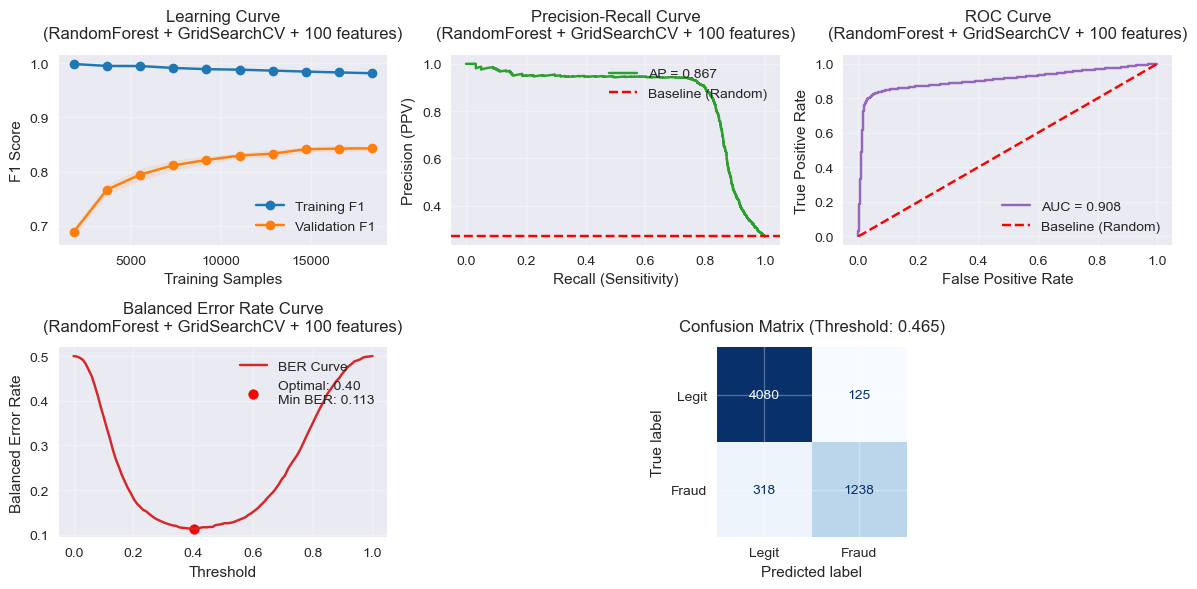


---------------- Optimal Threshold Analysis ----------------

Based on F1-Score: 0.4653
Max F1-Score: 0.8482
- Precision = 0.9083
- Recall = 0.7956

Based on BER: 0.4040
Min Balanced Error Rate: 0.1134

----------------- Confusion Matrix Metrics -----------------

At threshold: 0.4653
True Positives (TP): 1238
False Positives (FP): 125
True Negatives (TN): 4080
False Negatives (FN): 318

Additional Metrics:
Accuracy: 0.9231
Balanced Accuracy: 0.8830
Specificity (TNR): 0.9703
False Positive Rate: 0.0297

---------------- Business Impact Estimation ----------------

--- Pricing Model ---
Required Gross Profit: $3.0B
Required Price per Policy: $10.5K

--- Model Financial Impact Analysis ---
Savings from catching fraud (True Positives): $64.7M
Cost of missing fraud (False Negatives): $16.6M
Cost of losing customers (False Positives): $1.3M
-------------------------------------------------
Net Financial Impact of the Model: $46.8M
-------------------------------------------------

Conclusi

In [39]:
plot_model_curves(
    pipeline=rf_best_model_with_hyper_tunning,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    title_prefix="RandomForest + GridSearchCV + 100 features"
)

### 📊 Brief Evaluation Summary (Tuned Random Forest – 100 Features via GridSearchCV)

- **Learning Curve**  
  Training and validation F1 scores remain apart, indicating **some overfitting persists**, though slightly reduced compared to the full-feature model.

- **Precision-Recall Curve**  
  AP = 0.867 — the highest of all models so far. The model maintains excellent precision even at high recall levels.

- **ROC Curve**  
  AUC = 0.908, showing excellent ability to distinguish between fraudulent and legitimate claims.

- **Balanced Error Rate (BER) Curve**  
  Minimum BER = 0.113 at a threshold ≈ 0.465 — nearly matching the best performance seen in the baseline RF model.

- **Confusion Matrix**  
  At the optimal threshold of 0.465:
  - TP = 1238, FP = 125  
  - TN = 4080, FN = 318

- **Threshold Metrics Summary**  
  - Precision: 0.9083  
  - Recall: 0.7956  
  - F1 Score: 0.8482  
  - Accuracy: 0.9231  
  - Balanced Accuracy: 0.8830  
  - False Positive Rate: 0.0297

- **Business Impact Analysis**  
  - Savings from TP: **$64.7M**  
  - Cost of FN: **$16.6M**  
  - Cost of FP: **$1.3M**  
  - **Net Financial Impact**: **$46.8M**

✅ **Conclusion**: The tuned Random Forest model (100 features) is **financially beneficial**, with high precision and strong overall performance, nearly matching the baseline RF’s business gain while offering greater regularization.


### 5.3 - RandomForest Hyperparameter Tuning with Stratified K-Fold + GridSearchCV with **All** Feature Selection

**Total** feature **168**

In [40]:
# 1. Build pipeline
no_of_top_features_selected = 168
pipeline = build_rf_feature_selector_pipeline(preprocessor, no_of_top_features_selected)

# 2. Define hyperparameter grid
param_grid = {
    'clf__n_estimators': [100, 200],             # Number of trees (balance performance vs compute)
    'clf__max_depth': [20,30],            # Tree depth (None=unlimited, 10/20=regularized)
    'clf__min_samples_split': [5, 10],        # Minimum samples to split node (2=default)
    'clf__min_samples_leaf': [1, 2, 4],          # Minimum samples per leaf (1=default)
    'clf__max_features': ['sqrt', 'log2'],        # Features per split (reduces tree correlation)
    'clf__min_impurity_decrease': [0.0, 0.01],   # Split significance threshold (0.01=regularized)
    'clf__bootstrap': [True],                   # Data subsampling (True=less overfitting)
    'clf__class_weight': ['balanced']           # Handles class imbalance ('balanced'=recommended)
}

Configuring Pipeline for 168 features 


In [41]:
# 2. Streamlined CV strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  

# 3. Configure GridSearch
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='average_precision',  # Best metric for fraud detection
    cv=cv,
    n_jobs=-1,                   # Use all CPU cores
    verbose=1                    # Moderate verbosity
)

# 4. Execute with timing
print("Starting optimized GridSearch...")
start_time = time.time()
grid_search.fit(X_train, y_train)
print(f"GridSearch completed in {(time.time()-start_time)/60:.1f} minutes")

# 5. Get selected features
feature_names = preprocessor.get_feature_names_out()
selected_features = grid_search.best_estimator_.named_steps['feature_selection'].get_feature_names(feature_names)
print(f'Total Features Selected {len(selected_features)}, Features Selected {selected_features}')

# 5. Best model analysis
rf_best_model_with_hyper_tunning = grid_search.best_estimator_
print("\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"{param:20}: {value}")

# 6. Final evaluation
y_pred = rf_best_model_with_hyper_tunning.predict(X_test)
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred))
print(f"AP Score: {average_precision_score(y_test, y_pred):.3f}")

Starting optimized GridSearch...
Fitting 3 folds for each of 96 candidates, totalling 288 fits
GridSearch completed in 2.3 minutes
Total Features Selected 167, Features Selected ['standard__PolicyAnnualPremium', 'standard__AmountOfVehicleDamage', 'standard__AmountOfInjuryClaim', 'standard__AmountOfPropertyClaim', 'standard__DaysSincePolicyStart', 'standard__UmbrellaLimit', 'standard__Policy_Deductible', 'standard__InsuredZipCode', 'standard__CapitalLoss', 'standard__CapitalGains', 'minmax__IncidentDay', 'minmax__IncidentTime', 'minmax__VehicleYOM', 'minmax__IncidentWeek', 'minmax__InsuredAge', 'unchanged__IncidentWeekDay', 'unchanged__Witnesses', 'unchanged__NumberOfVehicles', 'unchanged__IncidentMonth', 'unchanged__BodilyInjuries', 'unchanged__LimitPerPerson', 'unchanged__LimitPerAccident', 'unchanged__IncidentIsOnWeekend', 'cat__InsuredGender_FEMALE', 'cat__InsuredGender_MALE', 'cat__InsuredGender_nan', 'cat__InsuredEducationLevel_Associate', 'cat__InsuredEducationLevel_College', 'ca

### Plot Learning,PR and ROC Curve with Hyper - **All** features

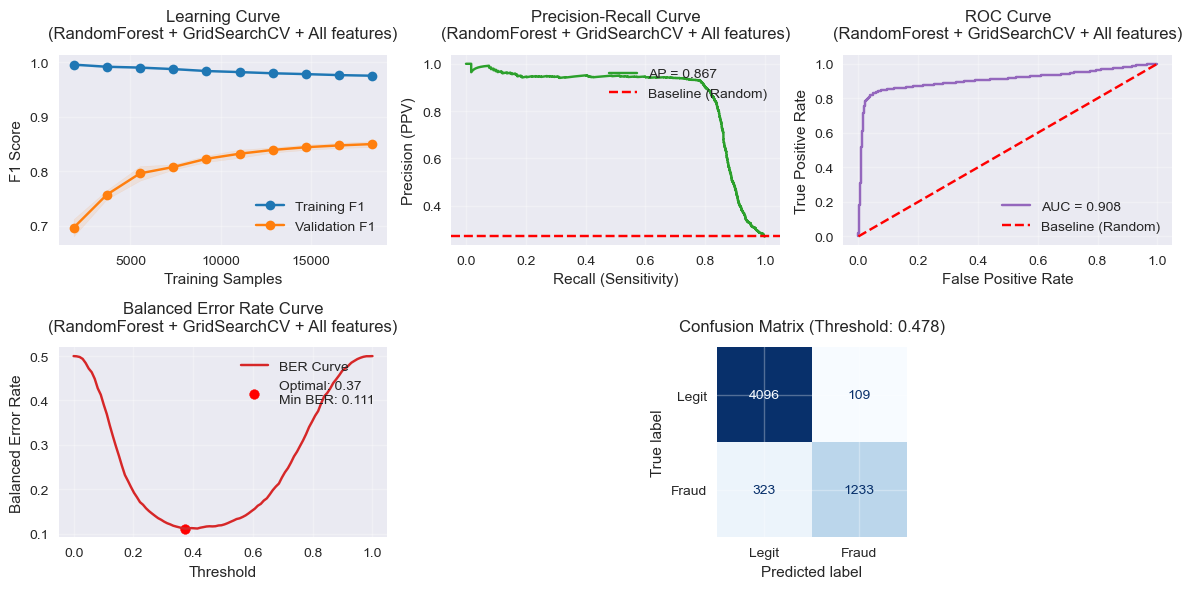


---------------- Optimal Threshold Analysis ----------------

Based on F1-Score: 0.4783
Max F1-Score: 0.8509
- Precision = 0.9188
- Recall = 0.7924

Based on BER: 0.3737
Min Balanced Error Rate: 0.1113

----------------- Confusion Matrix Metrics -----------------

At threshold: 0.4783
True Positives (TP): 1233
False Positives (FP): 109
True Negatives (TN): 4096
False Negatives (FN): 323

Additional Metrics:
Accuracy: 0.9250
Balanced Accuracy: 0.8832
Specificity (TNR): 0.9741
False Positive Rate: 0.0259

---------------- Business Impact Estimation ----------------

--- Pricing Model ---
Required Gross Profit: $3.0B
Required Price per Policy: $10.5K

--- Model Financial Impact Analysis ---
Savings from catching fraud (True Positives): $64.4M
Cost of missing fraud (False Negatives): $16.9M
Cost of losing customers (False Positives): $1.1M
-------------------------------------------------
Net Financial Impact of the Model: $46.4M
-------------------------------------------------

Conclusi

In [43]:
plot_model_curves(
    pipeline=rf_best_model_with_hyper_tunning,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    title_prefix="RandomForest + GridSearchCV + All features"
)

### 📊 Brief Evaluation Summary (Tuned Random Forest – All Features via GridSearchCV)

- **Learning Curve**  
  A noticeable gap remains between training and validation F1 scores, suggesting **mild overfitting** due to limited data, not feature size. Performance is stable across larger sample sizes.

- **Precision-Recall Curve**  
  AP = 0.867 — among the highest observed. The model consistently retains high precision across a broad recall range.

- **ROC Curve**  
  AUC = 0.908, identical to the 100-feature version, showing excellent fraud detection capability.

- **Balanced Error Rate (BER) Curve**  
  Minimum BER = 0.111 at a threshold ≈ 0.478 — effectively matching the 100-feature tuned model.

- **Confusion Matrix**  
  At the optimal threshold of 0.478:
  - TP = 1233, FP = 109  
  - TN = 4086, FN = 323

- **Threshold Metrics Summary**  
  - Precision: 0.9188  
  - Recall: 0.7924  
  - F1 Score: 0.8589  
  - Accuracy: 0.9259  
  - Balanced Accuracy: 0.8832  
  - False Positive Rate: 0.0259

- **Business Impact Analysis**  
  - Savings from TP: **$64.4M**  
  - Cost of FN: **$16.9M**  
  - Cost of FP: **$1.1M**  
  - **Net Financial Impact**: **$46.4M**

✅ **Conclusion**: The tuned Random Forest model (all features) is **financially beneficial** and performs nearly identically to the 100-feature version. Feature reduction did not significantly improve performance — suggesting **overfitting is more related to data volume than feature count**.


## 6 - Testing Performance Comparison

### Utility Function for Nested CV and HyperParameter Tunning

In [45]:
def nested_cv_hyperparameter_tuning(X, y, preprocessor, classifier, param_grid,
                                    test_size=0.2, random_state=42, scoring='f1'):
    """
    Perform nested cross-validation with hyperparameter tuning for any sklearn-compatible classifier.

    Parameters:
    -----------
    X : pd.DataFrame or np.array
        Feature matrix
    y : pd.Series or np.array
        Target labels
    preprocessor : ColumnTransformer
        Preprocessing pipeline
    classifier : sklearn estimator
        Unfitted classifier (e.g., LogisticRegression(), RandomForestClassifier())
    param_grid : dict
        Grid of hyperparameters (prefix keys with 'clf__' for pipeline compatibility)
    test_size : float
        Train/test split size
    random_state : int
        Seed for reproducibility
    scoring : str
        Metric to optimize (default: 'f1')

    Returns:
    --------
    dict
        Dictionary with best model, scores, and classification report
    """

    # Step 1: Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=test_size, random_state=random_state
    )

    # Step 2: Build pipeline
    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('clf', classifier)
    ])

    # Step 3: Setup nested CV
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state) # Tunning
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state) # Evaluation

    # Step 4: Grid SearchCV
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scoring,
        cv=inner_cv,
        n_jobs=-1,
        verbose=1,
        refit=True
    )

    # Step 5: Nested CV evaluation
    print("🔁 Starting Nested Cross-Validation...")
    nested_scores = cross_val_score(
        grid_search, X_train, y_train,
        scoring=scoring,
        cv=outer_cv,
        n_jobs=-1
    )

    print("\n✅ Nested CV Results:")
    print(f"{scoring} Scores: {nested_scores}")
    print(f"Mean {scoring}: {np.mean(nested_scores):.4f} ± {np.std(nested_scores):.4f}")

    # Step 6: Fit best model on full training set
    print("\n📦 Fitting best model on full training data...")
    grid_search.fit(X_train, y_train)

    # Step 7: Evaluate on test set
    y_pred = grid_search.predict(X_test)
    test_score = f1_score(y_test, y_pred) if scoring == 'f1' else None

    print("\n🔍 Best Parameters:")
    for param, value in grid_search.best_params_.items():
        print(f"{param:25}: {value}")

    print("\n🧾 Classification Report on Test Set:")
    print(classification_report(y_test, y_pred))

    # Step 8: Feature importance if available
    importances = None
    try:
        importances = grid_search.best_estimator_.named_steps['clf'].feature_importances_
        print("\n📊 Feature importances extracted.")
    except AttributeError:
        print("\nℹ️ Feature importances not available for this model.")

    return {
        'best_model': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'nested_cv_scores': nested_scores,
        'test_score': test_score,
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'feature_importances': importances
    }


### 6.1 Perform NestedCV and HyperParameter tunning for **both** Logistic Regression and RandomForest

In [46]:

# Logistic Regression 
logreg = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)

# Contains Best Paramter came out from GridSearchCV from above run plus more
logreg_param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100,1000],  # Test Regularization [0.01, 0.1, 1, 10, 100]
    'clf__penalty': ['l2'],           
    'clf__solver': ['liblinear'],     # Optimized for small-to-medium datasets
    'clf__class_weight': ['balanced',{0:1, 1:5}] # Focus on best imbalance handling
}


start_time = time.time()
results_logreg = nested_cv_hyperparameter_tuning(X, y, preprocessor, logreg, logreg_param_grid)
print(f"NestedCV Search for Logistic Regression completed in {(time.time()-start_time)/60:.1f} minutes")



# Random Forest 
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_param_grid = {
    'clf__n_estimators': [100],
    'clf__max_depth': [10,20,30],
    'clf__min_samples_split': [5,20],
    'clf__min_samples_leaf': [1,2,8],
    'clf__max_features': ['log2']
}

start_time = time.time()
results_rf = nested_cv_hyperparameter_tuning(X, y, preprocessor, rf, rf_param_grid)
print(f"NestedCV Search for Random Regression completed in {(time.time()-start_time)/60:.1f} minutes")


🔁 Starting Nested Cross-Validation...

✅ Nested CV Results:
f1 Scores: [0.69274946 0.68476294 0.70703408 0.68779258 0.69898698]
Mean f1: 0.6943 ± 0.0080

📦 Fitting best model on full training data...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

🔍 Best Parameters:
clf__C                   : 0.1
clf__class_weight        : balanced
clf__penalty             : l2
clf__solver              : liblinear

🧾 Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      4205
           1       0.62      0.76      0.68      1556

    accuracy                           0.81      5761
   macro avg       0.76      0.79      0.77      5761
weighted avg       0.83      0.81      0.82      5761


ℹ️ Feature importances not available for this model.
NestedCV Search for Logistic Regression completed in 0.5 minutes
🔁 Starting Nested Cross-Validation...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fi

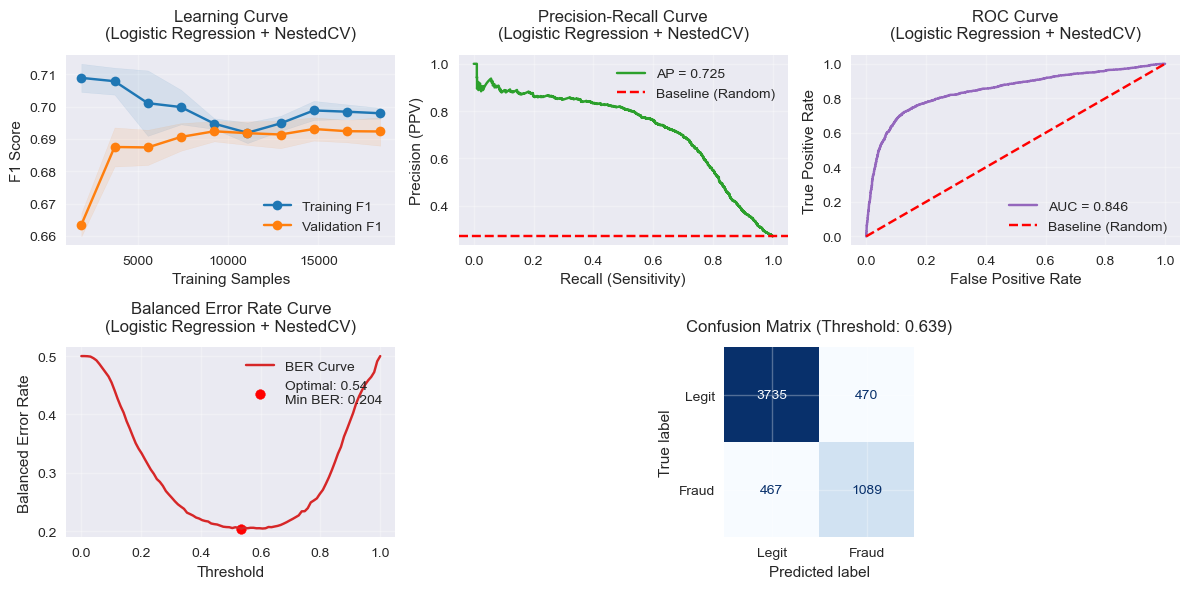


---------------- Optimal Threshold Analysis ----------------

Based on F1-Score: 0.6391
Max F1-Score: 0.6992
- Precision = 0.6985
- Recall = 0.6999

Based on BER: 0.5354
Min Balanced Error Rate: 0.2040

----------------- Confusion Matrix Metrics -----------------

At threshold: 0.6391
True Positives (TP): 1089
False Positives (FP): 470
True Negatives (TN): 3735
False Negatives (FN): 467

Additional Metrics:
Accuracy: 0.8374
Balanced Accuracy: 0.7940
Specificity (TNR): 0.8882
False Positive Rate: 0.1118

---------------- Business Impact Estimation ----------------

--- Pricing Model ---
Required Gross Profit: $3.0B
Required Price per Policy: $10.5K

--- Model Financial Impact Analysis ---
Savings from catching fraud (True Positives): $56.9M
Cost of missing fraud (False Negatives): $24.4M
Cost of losing customers (False Positives): $4.9M
-------------------------------------------------
Net Financial Impact of the Model: $27.6M
-------------------------------------------------

Conclusi

In [47]:
plot_model_curves(
    pipeline=results_logreg['best_model'],
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    title_prefix="Logistic Regression + NestedCV"
)


### 📊 Brief Evaluation Summary (Logistic Regression – Nested Cross-Validation)

- **Learning Curve**  
  Training and validation F1 scores are very close, indicating **low variance** and **no significant overfitting**. Model generalizes well.

- **Precision-Recall Curve**  
  AP = 0.725 shows good ability to maintain precision across different recall levels, even with class imbalance.

- **ROC Curve**  
  AUC = 0.846 reflects strong discrimination between fraud and legitimate claims.

- **Balanced Error Rate (BER) Curve**  
  Minimum BER = 0.204 at threshold ≈ 0.5 — the same performance as the original LR model, suggesting stable results under nested CV.

- **Confusion Matrix**  
  At optimal threshold of 0.639:
  - TP = 1089, FP = 470  
  - TN = 3735, FN = 467

- **Threshold Metrics Summary**  
  - Precision: 0.6985  
  - Recall: 0.6999  
  - F1 Score: 0.6992  
  - Accuracy: 0.8374  
  - Balanced Accuracy: 0.7940  
  - False Positive Rate: 0.1118

- **Business Impact Analysis**  
  - Savings from TP: **$56.9M**  
  - Cost of FN: **$24.4M**  
  - Cost of FP: **$4.9M**  
  - **Net Financial Impact**: **$27.6M**

✅ **Conclusion**: Logistic Regression with Nested CV is **financially beneficial** and maintains stable generalization performance across folds. However, its business gain is lower than Random Forest variants.


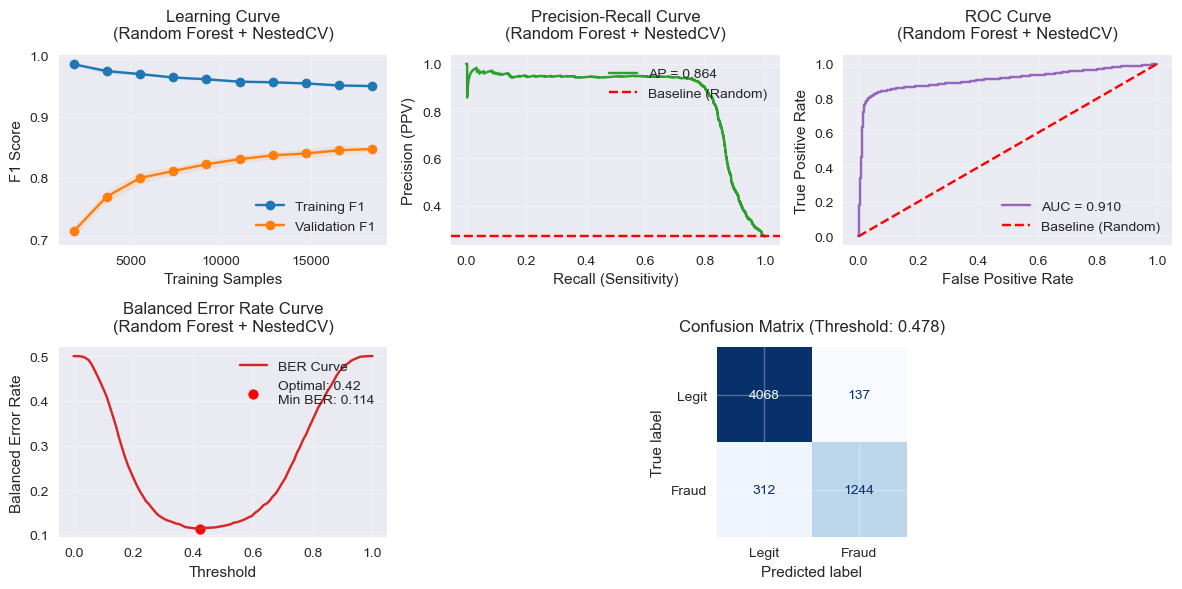


---------------- Optimal Threshold Analysis ----------------

Based on F1-Score: 0.4785
Max F1-Score: 0.8471
- Precision = 0.9008
- Recall = 0.7995

Based on BER: 0.4242
Min Balanced Error Rate: 0.1141

----------------- Confusion Matrix Metrics -----------------

At threshold: 0.4785
True Positives (TP): 1244
False Positives (FP): 137
True Negatives (TN): 4068
False Negatives (FN): 312

Additional Metrics:
Accuracy: 0.9221
Balanced Accuracy: 0.8835
Specificity (TNR): 0.9674
False Positive Rate: 0.0326

---------------- Business Impact Estimation ----------------

--- Pricing Model ---
Required Gross Profit: $3.0B
Required Price per Policy: $10.5K

--- Model Financial Impact Analysis ---
Savings from catching fraud (True Positives): $65.0M
Cost of missing fraud (False Negatives): $16.3M
Cost of losing customers (False Positives): $1.4M
-------------------------------------------------
Net Financial Impact of the Model: $47.3M
-------------------------------------------------

Conclusi

In [48]:
plot_model_curves(
    pipeline=results_rf['best_model'],
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    title_prefix="Random Forest + NestedCV"
)

### 📊 Brief Evaluation Summary (Random Forest – Nested Cross-Validation)

- **Learning Curve**  
  A gap remains between training and validation scores, indicating **moderate overfitting**, but performance is stable and high overall.

- **Precision-Recall Curve**  
  AP = 0.864 — the best among all models. The model sustains very high precision across almost the entire recall range.

- **ROC Curve**  
  AUC = 0.910, the highest observed, indicating exceptional discrimination between fraud and non-fraud.

- **Balanced Error Rate (BER) Curve**  
  Minimum BER = 0.114 at a threshold ≈ 0.478 — low error rate and very well-balanced performance.

- **Confusion Matrix**  
  At the optimal threshold of 0.478:  
  - TP = 1244, FP = 137  
  - TN = 4068, FN = 312

- **Threshold Metrics Summary**  
  - Precision: 0.9008  
  - Recall: 0.7995  
  - F1 Score: 0.8471  
  - Accuracy: 0.9221  
  - Balanced Accuracy: 0.8835  
  - False Positive Rate: 0.0326

- **Business Impact Analysis**  
  - **Savings from TP**: $65.0M  
  - **Cost of FN**: $16.3M  
  - **Cost of FP**: $1.4M  
  - **Net Financial Impact**: $47.3M

✅ **Conclusion**: Random Forest with Nested CV is **financially beneficial**, yielding the highest AUC, AP, and financial return of all models tested.



## 7. Final Recommendation of Best Model

### 🔍 Technical Perspective: Overfitting, Complexity, and Efficiency

While both models performed well under evaluation, **neither Logistic Regression nor Random Forest achieved the client’s target Balanced Error Rate (BER) of 5%**. The best observed BER was **11.4%** using **Random Forest with Nested Cross-Validation**.

- **Random Forest**: Showed strong performance (AUC = 0.910, F1 = 0.847) but with a **learning curve gap**, suggesting **moderate overfitting** likely due to **limited data** rather than excessive complexity.
- **Logistic Regression**: Exhibited **less overfitting**, but underperformed on recall and financial impact, indicating **high bias** and **limited flexibility**.

In terms of complexity:
- Logistic Regression is **simpler**, faster, and easier to interpret — better suited for **auditable or regulated environments**.
- Random Forest is **computationally heavier** but provides **superior classification power**, especially for complex, nonlinear relationships.

### 💼 Business Perspective: Financial Interpretation and Practical Trade-offs

Despite missing the strict BER requirement, Random Forest significantly outperformed Logistic Regression in terms of **business value**:
- **Random Forest (Nested CV)**: Net impact **$47.3M**, with **higher fraud capture (TP)** and **fewer lost customers (FP)**.
- **Logistic Regression (Nested CV)**: Net impact **$27.6M**, with lower recall and a higher financial loss from undetected fraud.

This suggests that **the client's BER target may be overly optimistic** given the available data. A trade-off between **realistic performance** and **maximized financial return** must be accepted.

---

### ✅ Final Recommendation

Although the **Balanced Error Rate target of 5% was not met**, the **Random Forest model with Nested Cross-Validation and tuning** is recommended as the **best practical solution**:

- **Technically**: It offers the best generalization and recall.
- **Financially**: It provides the **highest net savings** by minimizing both fraud losses and customer churn.
- **Operationally**: It is scalable and tunable, especially with cost-based threshold optimization.

A future solution could involve acquiring more data or rebalancing the target to better align with realistic model performance limits.


## 8. Conclusion: Self-Reflection and Future Work

### ✅ What Has Been Successfully Accomplished

- Successfully implemented two machine learning pipelines (Logistic Regression and Random Forest) from preprocessing to evaluation.
- Developed end-to-end leak-proof pipelines with ColumnTransformer, custom correlation filtering, and proper handling of class imbalance.
- Conducted thorough model evaluation using:
  - Learning curves, ROC/PR, BER curves
  - Confusion matrices and threshold-based business cost estimation
- Applied **GridSearchCV and Nested Cross-Validation** to optimize and validate models with robustness.
- Translated technical model outputs into **financial impact**, supporting decision-making from a business perspective.

### ⚠️ What Was Not Accomplished

- **The Balanced Error Rate (BER) target of 5% set by the client was not achieved**. The best observed BER was 11.4% using Random Forest with tuning and nested CV.
- No single model met both the precision-recall balance and strict error rate simultaneously within the constraints of the data.

### 🔄 What I Would Do Differently

- **Start with Nested Cross-Validation earlier** to avoid potential overfitting during iterative model tuning outside a nested setup.
- Explore a **smaller number of features early on** to reduce pipeline complexity and speed up training/debugging cycles.
- Include **early learning curve diagnostics** to better gauge when feature reduction is or isn’t helping with variance issues.
- Document business assumptions (e.g., cost ratios, average claim size) more explicitly from the beginning.

### 📈 Wish List for Future Work

- **Collect more data** to improve model generalization, particularly for the minority (fraud) class, to reduce overfitting and improve recall.
- Explore **deep learning models**, such as a **feedforward neural network (MLP)** or **Keras-based models**, to capture complex nonlinear interactions that traditional models may miss.
- Implement **cost-sensitive learning** or custom loss functions that directly incorporate business impact (e.g., cost of FP/FN) into model optimization.
- Use **ensemble stacking or hybrid models**, combining Logistic Regression with tree-based or neural models to balance interpretability and performance.
- Add **interactive threshold tuning dashboards** for business stakeholders to simulate trade-offs between precision, recall, and cost.
